In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from datetime import datetime

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [4]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### with/without N(z) prior
optical + irac data

In [3]:
cat_output_withprior = Table.read(graham_output_dir+'cat_out_nonir_il_nz_prior_formass.fits')
cat_output_noprior = Table.read(graham_output_dir+'cat_out_nonir_il_formass.fits')
cat_output_noprior = cat_output_noprior['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','PDZ_BEST','MASS_MED_massrun','MASS_INF','MASS_SUP']

cat_output = hstack([cat_output_withprior, cat_output_noprior],table_names=['p','np'])
cat_output.write(graham_output_dir+'cat_out_prior_check.fits', overwrite=True)

In [4]:
# match the output catalog with COSMOS2020 and save to disk
cat_output_name = graham_output_dir+'cat_out_prior_check.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = output_dir+'cat_out_prior_check_cosmosadded.fits'
col_list = "'RA DEC MASS_MED Z_ML'"

# matching cat_output and cat_c20
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
print(cmd)
os.system(cmd)

java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0       in1=/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_prior_check.fits values1="RA DEC"        in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits values2="ALPHA_J2000 DELTA_J2000"        in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC"        out=/Users/lejay/research/lephare_dev/my_code/output_cats/cat_out_prior_check_cosmosadded.fits icmd3="keepcols 'RA DEC MASS_MED Z_ML'" 


0

In [189]:
cat_matched = Table.read(output_dir+'cat_out_prior_check_cosmosadded.fits')
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
print(len(cat_matched))
cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
cat_matched = cat_matched[cat_matched['Z_ML_p']>0]
cat_matched = cat_matched[cat_matched['Z_ML_np']>0]
# cat_matched = cat_matched[cat_matched['flag_photoz']==1]


cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < 0.3) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < 0.3) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < 0.3) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < 0.3) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < 0.3) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < 0.3) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < 0.3) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < 0.3) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < 0.3) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < 0.3) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < 0.3) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

cond_massive_c20 = (cat_matched['lp_mass_med']>11.2)
cond_massive = (cat_matched['MASS_MED_massrun_np']>11.2)

24036


/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


*************
No Prior
my masive gals: 289(241)
mass agree with c20 within 0.3: 167
c20 massive gals: 123
purity: 104 / 289
completeness: 104 / 123
*************
With Prior
my masive gals: 255(241)
mass agree with c20 within 0.3: 169
c20 massive gals: 123
purity: 104 / 255
completeness: 104 / 123
*************
No Prior (flag irac >= 2)
my masive gals: 206
mass agree with c20 within 0.3: 162
c20 massive gals: 123
purity: 102 / 206
completeness: 102 / 123
*************
With Prior (flag irac >= 2)
my masive gals: 204
mass agree with c20 within 0.3: 165
c20 massive gals: 123
purity: 103 / 204
completeness: 103 / 123


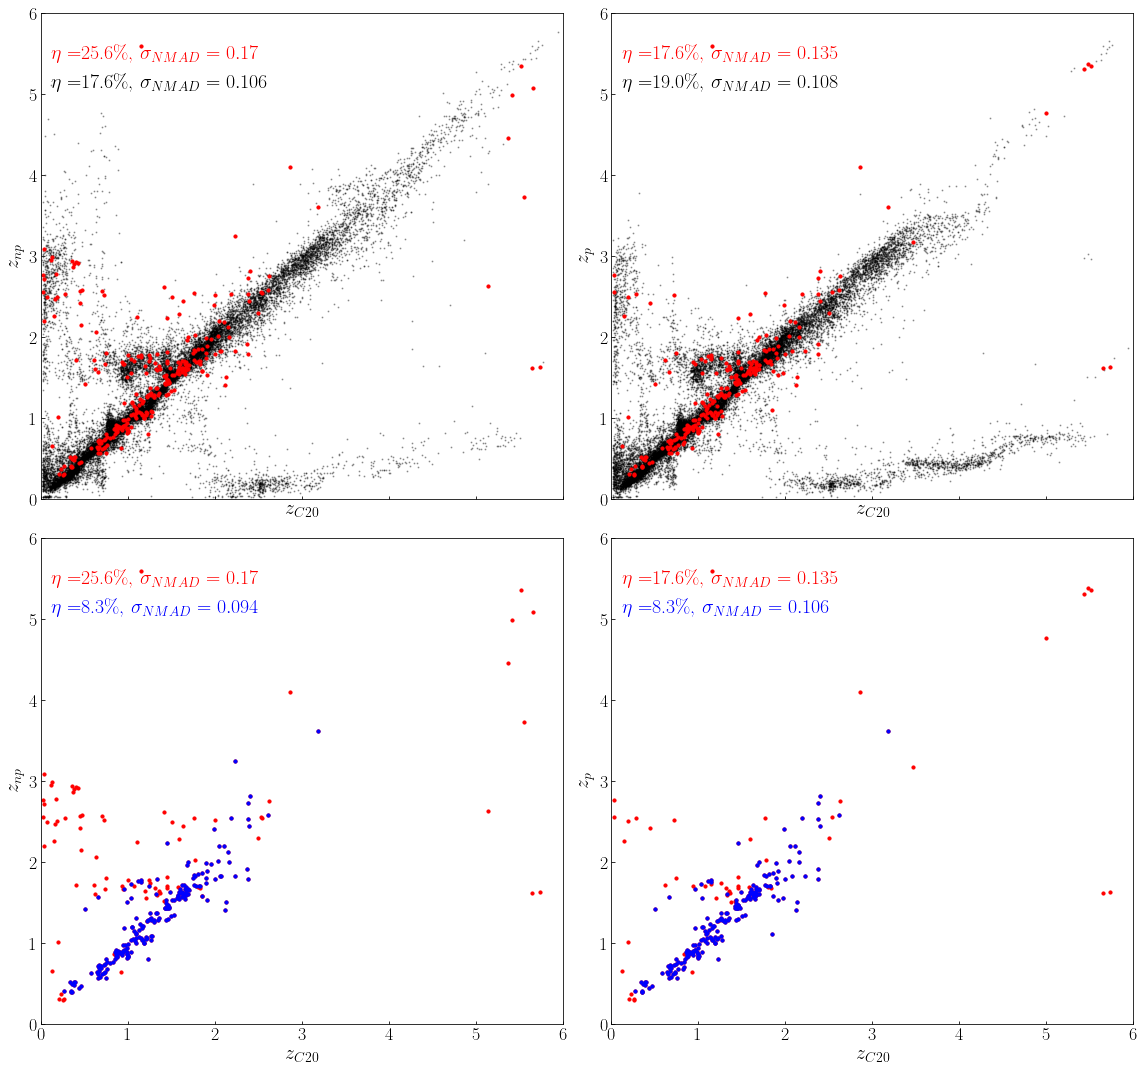

In [190]:
# redshift comparison
outlier_factor = 0.15
cat=cat_matched
massive_cut = 11.2

fig, axs = plt.subplots(2, 2, figsize = (16, 15),sharex=True)
colors= ['red','red']
for i in range(2):
    for j,run_type in enumerate(['np','p']):
        if run_type == 'p':
            massive_cond = cat['MASS_MED_massrun_p']>massive_cut
        else:
            massive_cond = cat['MASS_MED_massrun_np']>massive_cut
        
        # print completeness/purity
        if i==0:
            massive_both = cat[np.logical_and(cat['MASS_MED_massrun_p']>massive_cut,cat['MASS_MED_massrun_np']>massive_cut)]
            my_massive = cat[massive_cond]
            c20_massive = cat[cat['lp_mass_med']>massive_cut]
            print('*************')
            if run_type == 'p':
                print('With Prior')
            else:
                print('No Prior')
            print('my masive gals:', str(len(my_massive))+'('+str(len(massive_both))+')')
            print('mass agree with c20 within 0.3:',len(my_massive[abs(my_massive['MASS_MED_massrun_'+run_type]-my_massive['lp_mass_med'])<0.3]))
            print('c20 massive gals:',len(c20_massive))
            print('purity:',len(np.intersect1d(np.array(my_massive['STRING_INPUT']),np.array(c20_massive['STRING_INPUT']))),'/',len(my_massive))
            print('completeness:',len(np.intersect1d(np.array(my_massive['STRING_INPUT']),np.array(c20_massive['STRING_INPUT']))),'/',len(c20_massive))
            
            # plot
            axs[i][j].scatter(cat['lp_zPDF'],cat['Z_ML_'+run_type],s=1, color='k',alpha=0.3)
            axs[i][j].scatter(cat[massive_cond]['lp_zPDF'],cat[massive_cond]['Z_ML_np'],s=10, color='r')
            
            num_outliers = len(cat[abs(cat['lp_zPDF']-cat['Z_ML_'+run_type])>outlier_factor*(1+cat['lp_zPDF'])])
            num_outliers_massive = len(cat[massive_cond][abs(cat[massive_cond]['lp_zPDF']-cat[massive_cond]['Z_ML_'+run_type])>outlier_factor*(1+cat[massive_cond]['lp_zPDF'])])
            deltaz = np.array(cat['Z_ML_'+run_type]-cat['lp_zPDF'])
            deltaz_massive = np.array(cat[massive_cond]['Z_ML_'+run_type]-cat[massive_cond]['lp_zPDF'])
            sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
            sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
            axs[i][j].annotate('$\eta=$'+str(round(num_outliers/len(cat)*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
            axs[i][j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[massive_cond])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color=colors[i])
            
        else:
            cond1 = massive_cond & (flag_irac>=2) & (flag_optical>=2)
            my_massive = cat[cond1]
            c20_massive = cat[cat['lp_mass_med']>massive_cut]
            print('*************')
            if run_type == 'p':
                print('With Prior (flag irac >= 2)')
            else:
                print('No Prior (flag irac >= 2)')
            print('my masive gals:', str(len(my_massive)))
            print('mass agree with c20 within 0.3:',len(my_massive[abs(my_massive['MASS_MED_massrun_'+run_type]-my_massive['lp_mass_med'])<0.3]))
            print('c20 massive gals:',len(c20_massive))
            print('purity:',len(np.intersect1d(np.array(my_massive['STRING_INPUT']),np.array(c20_massive['STRING_INPUT']))),'/',len(my_massive))
            print('completeness:',len(np.intersect1d(np.array(my_massive['STRING_INPUT']),np.array(c20_massive['STRING_INPUT']))),'/',len(c20_massive))
            
            color_lables = ['r','b']
            ys = [0.9, 0.84]
            for k, cond in enumerate([massive_cond, cond1]):  
                axs[i][j].scatter(cat[cond]['lp_zPDF'],cat[cond]['Z_ML_np'],s=10, c=color_lables[k])
            
                num_outliers_massive = len(cat[cond][abs(cat[cond]['lp_zPDF']-cat[cond]['Z_ML_'+run_type])>outlier_factor*(1+cat[cond]['lp_zPDF'])])
                deltaz_massive = np.array(cat[cond]['Z_ML_'+run_type]-cat[cond]['lp_zPDF'])
                sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
                axs[i][j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[cond])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,ys[k]]),xycoords='axes fraction',fontsize=20,color=color_lables[k])
            
        axs[i][j].set_xlabel('$z_{C20}$',fontsize=20)
        axs[i][j].set_ylabel('$z_{'+run_type+'}$',fontsize=20)
        axs[i][j].set_xlim([0,6])
        axs[i][j].set_ylim([0,6])
plt.tight_layout()

#### lower limit treatment vs. no treatment

In [14]:
cat_output_withlimit = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_23.2_formass.fits') #23.2

cat_output_limit235 = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_23.5_formass.fits')
cat_output_limit235 = cat_output_limit235['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','MASS_MED_massrun','MASS_INF','MASS_SUP']

cat_output_limit224 = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_22.4_formass.fits')
cat_output_limit224 = cat_output_limit224['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','MASS_MED_massrun','MASS_INF','MASS_SUP']

cat_output_nolimit = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits')
cat_output_nolimit = cat_output_nolimit['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','MASS_MED_massrun','MASS_INF','MASS_SUP']

cat_output = hstack([cat_output_withlimit, cat_output_nolimit,cat_output_limit235,cat_output_limit224],table_names=['l','nl','l235','l224'])
cat_output.write(graham_output_dir+'cat_out_limit_check.fits', overwrite=True)

In [15]:
# match the output catalog with COSMOS2020 and save to disk
cat_output_name = graham_output_dir+'cat_out_limit_check.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = output_dir+'cat_out_limit_check_cosmosadded.fits'
col_list = "'RA DEC MASS_MED Z_ML'"

# matching cat_output and cat_c20
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
print(cmd)
os.system(cmd)

java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0       in1=/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_limit_check.fits values1="RA DEC"        in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits values2="ALPHA_J2000 DELTA_J2000"        in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC"        out=/Users/lejay/research/lephare_dev/my_code/output_cats/cat_out_limit_check_cosmosadded.fits icmd3="keepcols 'RA DEC MASS_MED Z_ML'" 


0

In [16]:
cat_matched = Table.read(output_dir+'cat_out_limit_check_cosmosadded.fits')
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
print(len(cat_matched))
cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
cat_matched = cat_matched[cat_matched['Z_ML_l']>0]
cat_matched = cat_matched[cat_matched['Z_ML_nl']>0]


cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < 0.3) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < 0.3) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < 0.3) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < 0.3) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < 0.3) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < 0.3) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < 0.3) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < 0.3) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < 0.3) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < 0.3) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < 0.3) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

cond_massive_c20 = (cat_matched['lp_mass_med']>11.2)
cond_massive = (cat_matched['MASS_MED_massrun_nl']>11.2)

96651


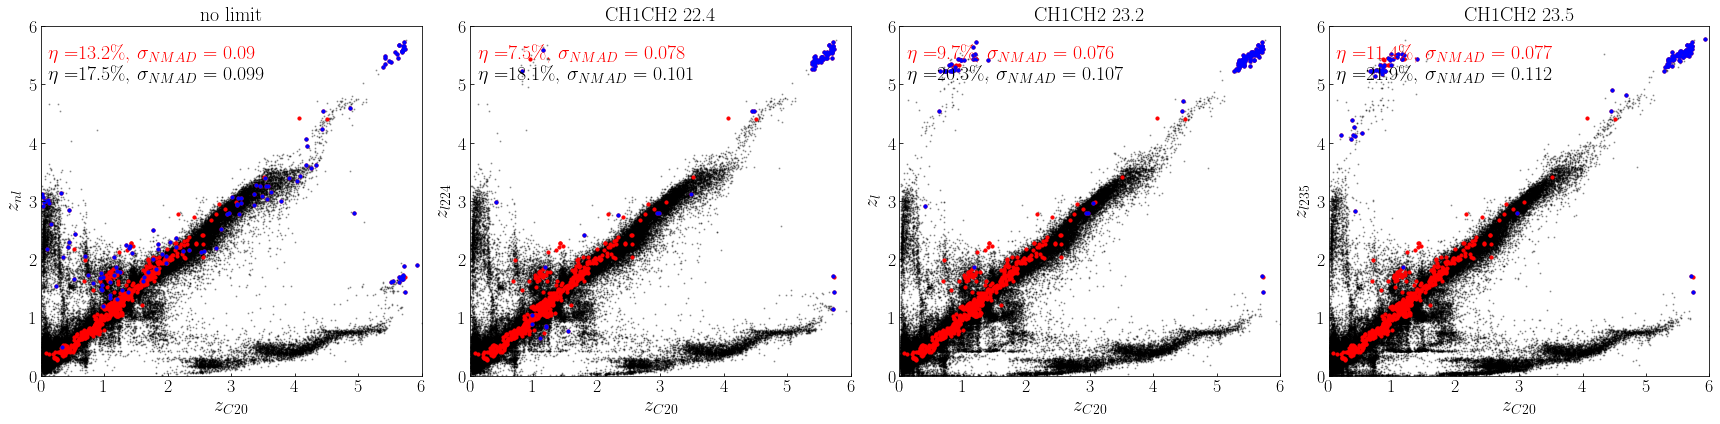

In [17]:
# redshift comparison
outlier_factor = 0.15
cat=cat_matched
massive_cut = 11.2
titles = ['no limit','CH1CH2 22.4','CH1CH2 23.2','CH1CH2 23.5']
fig, axs = plt.subplots(1, 4, figsize = (24, 6),sharex=True)
colors= ['red','red']

for j,run_type in enumerate(['nl','l224','l','l235']):
    massive_cond = cat['MASS_MED_massrun_'+run_type]>massive_cut
    my_massive = cat[massive_cond]
    c20_massive = cat[cat['lp_mass_med']>massive_cut]
        
    # plot
    axs[j].scatter(cat['lp_zPDF'],cat['Z_ML_'+run_type],s=1, color='k',alpha=0.3)
    axs[j].scatter(cat[massive_cond]['lp_zPDF'],cat[massive_cond]['Z_ML_'+run_type],s=10, color='r')
    axs[j].scatter(cat[massive_cond  & (flag_irac==0)]['lp_zPDF'],cat[massive_cond & (flag_irac==0)]['Z_ML_'+run_type],s=10, color='b')
            
    num_outliers = len(cat[abs(cat['lp_zPDF']-cat['Z_ML_'+run_type])>outlier_factor*(1+cat['lp_zPDF'])])
    num_outliers_massive = len(cat[massive_cond][abs(cat[massive_cond]['lp_zPDF']-cat[massive_cond]['Z_ML_'+run_type])>outlier_factor*(1+cat[massive_cond]['lp_zPDF'])])
    deltaz = np.array(cat['Z_ML_'+run_type]-cat['lp_zPDF'])
    deltaz_massive = np.array(cat[massive_cond]['Z_ML_'+run_type]-cat[massive_cond]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
    axs[j].annotate('$\eta=$'+str(round(num_outliers/len(cat)*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    axs[j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[massive_cond])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='r')   
    axs[j].set_title(titles[j],fontsize=20)
    axs[j].set_xlabel('$z_{C20}$',fontsize=20)
    axs[j].set_ylabel('$z_{'+run_type+'}$',fontsize=20)
    axs[j].set_xlim([0,6])
    axs[j].set_ylim([0,6])
    
plt.tight_layout()

In [9]:
sigma_list = []
sigma_massive_list = []
eta_list = []
eta_massive_list = []
fig, axs = plt.subplots(2, 7, figsize = (35, 6),sharex=True)  
for i,limit in enumerate(['215','219','220','221','222','224', '225', '226','227','228', '229']):
    cat_name = graham_output_dir + 'cat_out_nonir_il_limit'+limit+'_formass.fits'
    cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
    combined_cat_name = graham_output_dir + 'cat_out_nonir_il_limit'+limit+'_formassc20added.fits'
    col_list = "'RA DEC MASS_MED'"
    
    # matching cat_output and cat_c20
    cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
    os.system(cmd)
    
    cat_matched = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
    arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
    cat_matched = cat_matched[ind]
    cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
    cat_matched = cat_matched[cat_matched['Z_ML']>0]
    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
    
    cat=cat_matched
    massive_cond = cat['MASS_MED_massrun']>massive_cut
    my_massive = cat[massive_cond]
    
    row = i//7
    col = i%7
    axs[row][col].scatter(cat['lp_zPDF'],cat['Z_ML'],s=1, color='k',alpha=0.3)
    axs[row][col].scatter(cat[massive_cond]['lp_zPDF'],cat[massive_cond]['Z_ML'],s=10, color='r')
    axs[row][col].scatter(cat[massive_cond & (flag_irac==0)]['lp_zPDF'],cat[massive_cond & (flag_irac==0)]['Z_ML'],s=10, color='b')
    axs[row][col].set_title(limit,fontsize=15)
    num_outliers = len(cat[abs(cat['lp_zPDF']-cat['Z_ML'])>outlier_factor*(1+cat['lp_zPDF'])])
    num_outliers_massive = len(cat[massive_cond][abs(cat[massive_cond]['lp_zPDF']-cat[massive_cond]['Z_ML'])>outlier_factor*(1+cat[massive_cond]['lp_zPDF'])])
    deltaz = np.array(cat['Z_ML']-cat['lp_zPDF'])
    deltaz_massive = np.array(cat[massive_cond]['Z_ML']-cat[massive_cond]['lp_zPDF'])
    
    sigma = round(1.4826*np.median(abs(deltaz - np.median(deltaz))),5)
    sigma_massive = round(1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive))),5)
    eta = round(num_outliers/len(cat)*100,3)
    eta_massive = round(num_outliers_massive/len(cat[massive_cond])*100,3)
    sigma_list.append(sigma)
    sigma_massive_list.append(sigma_massive)
    eta_list.append(eta)
    eta_massive_list.append(eta_massive)

print(sigma_list)
print(sigma_massive_list)
print(eta_list)
print(eta_massive_list)

fig, axs = plt.subplots(1, 2, figsize = (11, 5),sharex=True)    
limits = [21.5,21.9,22.0,22.1,22.2,22.4,22.5,22.6,22.7,22.8,22.9]
axs[0].plot(limits,sigma_list,color='k')
axs[0].plot(limits,sigma_massive_list,color='r')
axs[0].set_ylabel('$\sigma$',fontsize=18)
axs[1].plot(limits,eta_list,color='k')
axs[1].plot(limits,eta_massive_list,color='r')
axs[1].set_ylabel('outlier fraction',fontsize=18)


/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[0.10393, 0.10363, 0.10363, 0.10408, 0.10378, 0.10349, 0.10378, 0.10378, 0.10393, 0.10467, 0.10482]
[0.104, 0.09978, 0.10022, 0.10022, 0.10304, 0.0937, 0.09963, 0.10008, 0.09288, 0.09437, 0.09733]
[17.012, 16.938, 17.009, 17.077, 17.165, 17.306, 17.388, 17.551, 17.689, 17.832, 17.992]
[11.062, 11.111, 11.161, 11.607, 11.062, 10.959, 11.765, 11.712, 11.818, 11.818, 11.712]


Text(0, 0.5, 'outlier fraction')

#### i-irac1 colors

In [62]:
cat_output_no_nir_mass_name = graham_output_dir+'cat_out_nonir_il_formass.fits'
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits').replace('.fits','_sfq_added.fits'))

detect_labels = []
for gal in cat:
    if gal['sfq_nuvrk_myrun'] ==0: #Q
        irac = gal['i'] - (3.4*gal['Z_ML']-0.8)
    else: #SF
        irac = gal['i'] - (1.4*gal['Z_ML']-0.8)
    
    if irac < 23 and gal['MAG_AUTO_CH1_CORR']<-90:
        detect_labels.append(1)
    else:
        detect_labels.append(0)

detect_labels = np.array(detect_labels)

In [70]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True)

plt.scatter(cat['lp_zPDF'],cat['Z_ML'],s=1, c=detect_labels,alpha=0.3)
plt.xlim([0,6])
plt.ylim([0,6])
plt.colorbar()

#### apply shift changes

In [3]:
cat_output_noshift = Table.read(graham_output_dir+'cat_out_nonir_il_noshift_formass.fits')
cat_output_autoadapt = Table.read(graham_output_dir+'cat_out_nonir_il_formass.fits')
cat_output_autoadapt = cat_output_autoadapt['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','PDZ_BEST','MASS_MED_massrun','MASS_INF','MASS_SUP']
cat_output_autoadapt_bc03 = Table.read(graham_output_dir+'cat_out_nonir_bc03shift_formass.fits')
cat_output_autoadapt_bc03 = cat_output_autoadapt_bc03['Z_BEST','Z_ML','Z_ML68_LOW','Z_ML68_HIGH','PDZ_BEST','MASS_MED_massrun','MASS_INF','MASS_SUP']

# stack
cat_output = hstack([cat_output_noshift, cat_output_autoadapt,cat_output_autoadapt_bc03],table_names=['ns','auto','bc03'])
cat_output.write(graham_output_dir+'cat_out_magshift_check.fits', overwrite=True)

In [64]:
# match the output catalog with COSMOS2020 and save to disk
cat_output_name = graham_output_dir+'cat_out_magshift_check.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = output_dir+'cat_out_magshift_check_cosmosadded.fits'
col_list = "'RA DEC MASS_MED Z_ML'"

# matching cat_output and cat_c20
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
print(cmd)
os.system(cmd)

java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0       in1=/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_magshift_check.fits values1="RA DEC"        in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits values2="ALPHA_J2000 DELTA_J2000"        in3=/Volumes/LejaySSD/v11_cats/COSMOS6bandesv11_bc03_zphot.fits values3="RA DEC"        out=/Users/lejay/research/lephare_dev/my_code/output_cats/cat_out_magshift_check_cosmosadded.fits icmd3="keepcols 'RA DEC MASS_MED Z_ML'" 


0

In [65]:
cat_matched = Table.read(output_dir+'cat_out_magshift_check_cosmosadded.fits')
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
print(len(cat_matched))
cat_matched = cat_matched[cat_matched['lp_zPDF']>0]


cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < 0.3) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < 0.3) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < 0.3) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < 0.3) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < 0.3) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < 0.3) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < 0.3) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < 0.3) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < 0.3) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < 0.3) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < 0.3) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

cond_massive_c20 = (cat_matched['lp_mass_med']>11.2)
cond_massive = (cat_matched['MASS_MED_massrun_ns']>11.2)

24036


/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


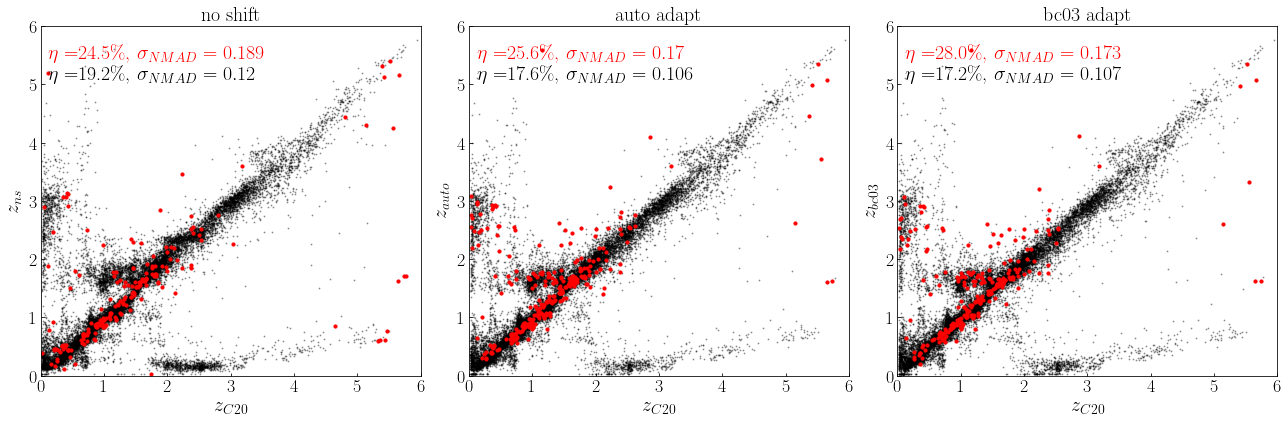

In [66]:
# redshift comparison
outlier_factor = 0.15
cat=cat_matched
massive_cut = 11.2
titles = ['no shift','auto adapt','bc03 adapt']
fig, axs = plt.subplots(1, 3, figsize = (18, 6),sharex=True)
colors= ['red','red']
for j,run_type in enumerate(['ns','auto','bc03']):
    massive_cond = cat['MASS_MED_massrun_'+run_type]>massive_cut
    my_massive = cat[massive_cond]
    c20_massive = cat[cat['lp_mass_med']>massive_cut]
        
    # plot
    axs[j].scatter(cat['lp_zPDF'],cat['Z_ML_'+run_type],s=1, color='k',alpha=0.3)
    axs[j].scatter(cat[massive_cond]['lp_zPDF'],cat[massive_cond]['Z_ML_'+run_type],s=10, color='r')
            
    num_outliers = len(cat[abs(cat['lp_zPDF']-cat['Z_ML_'+run_type])>outlier_factor*(1+cat['lp_zPDF'])])
    num_outliers_massive = len(cat[massive_cond][abs(cat[massive_cond]['lp_zPDF']-cat[massive_cond]['Z_ML_'+run_type])>outlier_factor*(1+cat[massive_cond]['lp_zPDF'])])
    deltaz = np.array(cat['Z_ML_'+run_type]-cat['lp_zPDF'])
    deltaz_massive = np.array(cat[massive_cond]['Z_ML_'+run_type]-cat[massive_cond]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
    axs[j].annotate('$\eta=$'+str(round(num_outliers/len(cat)*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    axs[j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[massive_cond])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='r')   
    axs[j].set_title(titles[j],fontsize=20)
    axs[j].set_xlabel('$z_{C20}$',fontsize=20)
    axs[j].set_ylabel('$z_{'+run_type+'}$',fontsize=20)
    axs[j].set_xlim([0,6])
    axs[j].set_ylim([0,6])
    
plt.tight_layout()

### Comparisons to C20 with 4 photometry configs
1. UV - y
2. UV -y and IRAC
3. UV- Ks
4. UV - IRAC

#### Loading and matching with C20

In [6]:
# the output catalogs (after photoz and mass runs)
cat_output_no_irac_nir_mass_name = output_dir+'cat_out_noniriracil_formass.fits'
cat_output_no_irac_mass_name = output_dir+'cat_out_noirac_il_formass.fits'
cat_output_no_nir_mass_name = output_dir+'cat_out_nonir_il_formass.fits'
cat_output_full_mass_name = output_dir+'cat_out_15band_il_formass.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']

In [15]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
sfq_added = '_sfq_added'
# nz_prior = ''
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
print(cat_names[0])

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonirirac_il_nz_prior_nolimit_formass_sfq_added.fits


In [17]:
for i,cat_name in enumerate(cat_names):    
#     print(cat_name)
    cat_output_name = cat_name
    cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
    combined_cat_name = cat_output_name.replace('_sfq_added.fits','c20added.fits')
    
    col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
    cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
    # print(cmd)
    os.system(cmd)
    
    cat_original = Table.read(cat_output_name)
    cat_matched = Table.read(combined_cat_name)
    arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
    cat_matched = cat_matched[ind]
    cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
    cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
    cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
    cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
    
    max_phot_err = 0.15
    cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err) )| \
             ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err) )
    cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err) ) 
    cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err) )
    cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
    cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
    cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
    flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

    cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
    cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
    cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
    cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
    flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
    
    flag_list = [flag_optical,flag_nir,flag_irac,flag_nir]
    flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
        
    if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
        print('lengths do not match')
    else:
        print(cat_output_name)
        print(len(cat_matched),'/',len(cat_original))
        
        col_flag_optical = Column(name='flag_optical', data=flag_optical)
        col_flag_nir = Column(name='flag_nir', data=flag_nir)
        col_flag_irac = Column(name='flag_irac', data=flag_irac)
        col_log_ezmass = Column(name='log_ez_mass_p500', data=np.log10(cat_matched['ez_mass_p500']))
        if 'flag_optical' in cat_matched.keys():
            cat_matched.remove_column('flag_optical')
        if 'flag_nir' in cat_matched.keys():
            cat_matched.remove_column('flag_nir')
        if 'flag_irac' in cat_matched.keys():
            cat_matched.remove_column('flag_irac')
        if 'log_ez_mass_p500' in cat_matched.keys():
            cat_matched.remove_column('log_ez_mass_p500')
            
        cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac,col_log_ezmass])
        cat_matched.write(combined_cat_name, overwrite=True)
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonirirac_il_nz_prior_nolimit_formass_sfq_addedc20added.fits'

In [13]:
# add sfq_info
# see lephare_nuvrk notebook

#### Mass/mag - redshift  plots

Text(0, 0.5, 'flag IRAC')

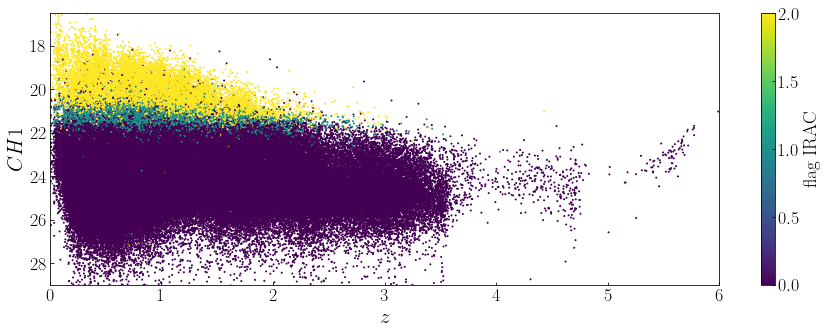

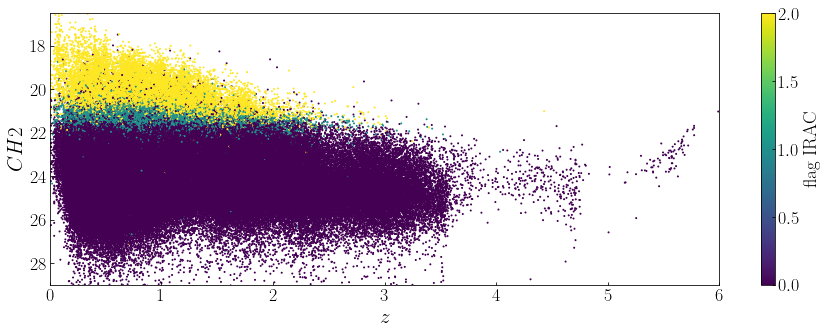

In [6]:
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
fig, axs = plt.subplots(1, 1, figsize = (15, 5),sharex=True, sharey=True)

im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c=cat['flag_irac'])
# im = plt.scatter(cat['lp_zPDF'],cat['lp_mass_med'],s=1,c=cat['flag_irac'])
plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,6])
plt.ylim([7,12.5])
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=19)

####
fig, axs = plt.subplots(1, 1, figsize = (15, 5),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['IRAC_CH1_MAG_1'],s=1,c=cat['flag_irac'])
plt.xlabel('$z$',fontsize=21)
plt.ylabel('$CH1$',fontsize=21)
plt.xlim([0,6])
plt.ylim([29,16.5])
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=19)

####
fig, axs = plt.subplots(1, 1, figsize = (15, 5),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['IRAC_CH1_MAG_2'],s=1,c=cat['flag_irac'])
plt.xlabel('$z$',fontsize=21)
plt.ylabel('$CH2$',fontsize=21)
plt.xlim([0,6])
plt.ylim([29,16.5])
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=19)

#### PDZ check

In [89]:
cat_output_c20added = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_nonir_il_formass.fits'.replace('.fits','c20added.fits'))

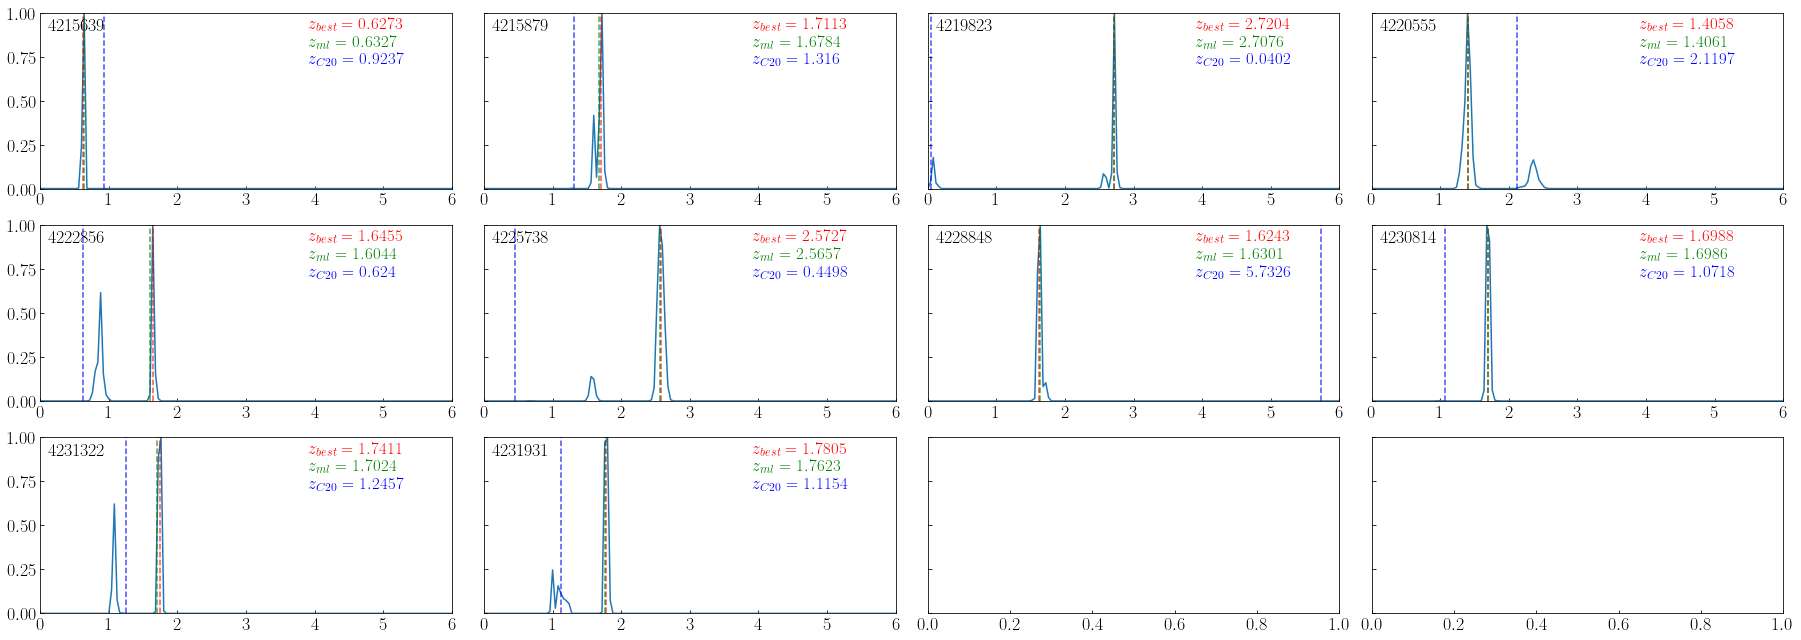

In [139]:
cat_outliers = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>11.2]
cat_outliers = cat_outliers[abs(cat_outliers['Z_ML']-cat_outliers['lp_zPDF'])>0.15*(1+cat_outliers['lp_zPDF'])]
cat_outliers = cat_outliers[7:17]

fig, axs = plt.subplots(len(cat_outliers)//4+1, 4, figsize = (25, (len(cat_outliers)//4+1)*3), sharey=True)
for i,gal in enumerate(cat_outliers):
    pdz = np.array(gal['pdz'].split(',')).astype(float)
    pdz_zbins = np.linspace(0,6,len(pdz))
    ID = gal['STRING_INPUT']
    z_best = gal['Z_BEST']
    z_ml = gal['Z_ML']
    z_c20 = gal['lp_zPDF']
    
    row = i//4
    col = i%4
    axs[row][col].plot(pdz_zbins,pdz)
    axs[row][col].annotate(ID,xy=([0.02,0.9]),xycoords='axes fraction',fontsize=18,color='k')
    axs[row][col].plot([z_best,z_best],[0,1],'--r',alpha=0.7)
    axs[row][col].plot([z_ml,z_ml],[0,1],'--g',alpha=0.7)
    axs[row][col].plot([z_c20,z_c20],[0,1],'--b',alpha=0.7)
    axs[row][col].annotate('$z_{best}='+str(z_best)+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=17,color='r')
    axs[row][col].annotate('$z_{ml}='+str(z_ml)+'$',xy=([0.65,0.8]),xycoords='axes fraction',fontsize=17,color='g')
    axs[row][col].annotate('$z_{C20}='+str(z_c20)+'$',xy=([0.65,0.7]),xycoords='axes fraction',fontsize=17,color='b')
    
    axs[row][col].set_xlim([0,6])
    axs[row][col].set_ylim([0,1])
    
plt.tight_layout()

#### redshift comparison plots

In [7]:
massive_cut = 11.2

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonirirac_il_nz_prior_nolimit_formass.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_noirac_il_nz_prior_nolimit_formass.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits
Number of objects (with irac): 17277
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_allphot_il_nz_prior_nolimit_formass.fits
Number of objects (with irac): 685
Number of objects (with irac): 509


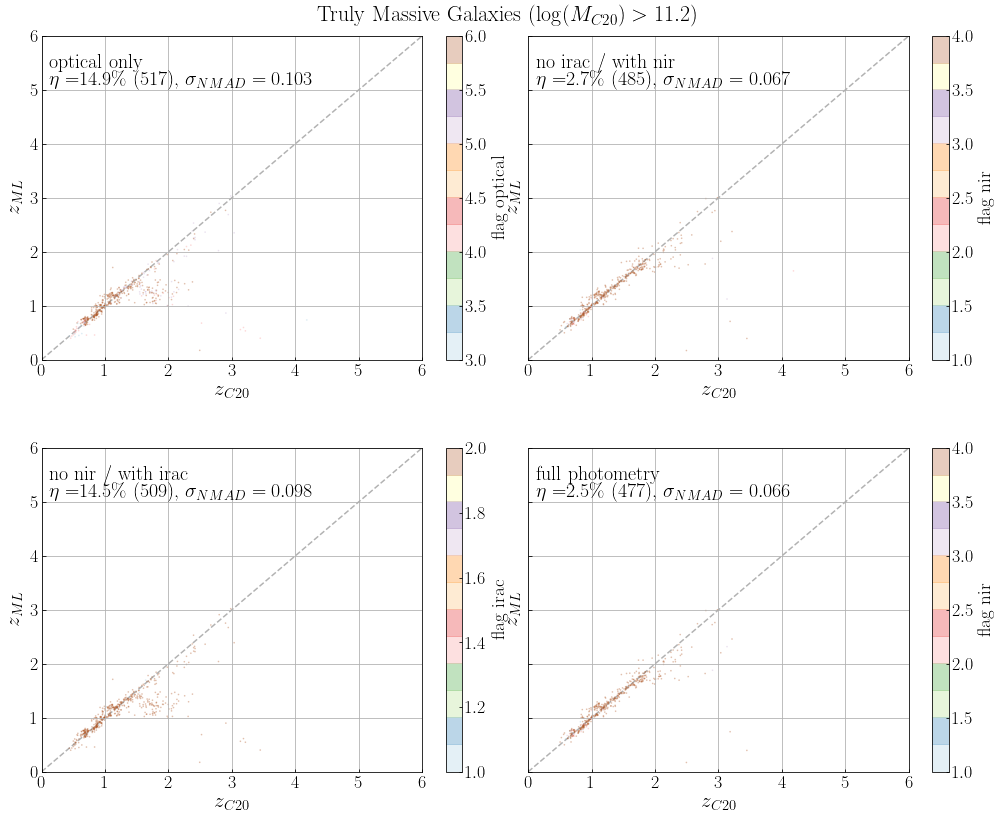

In [8]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/lejay/Desktop/lephare_photoz_comparison.pdf")
z_keyname = 'Z_ML'
for selection in ['all','massive','massive_c20']:
    fig, axs = plt.subplots(2, 2, figsize = (15, 12), sharey=True)
    for i,cat_name in enumerate(cat_names):
        row = i // 2
        col = i % 2
        
        # load catalog
        if selection=='all':
            print(cat_name)
            
        cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
        cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
        
        # flags
        flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
        flag_filter = cat_output_c20added[flag_name_list[i]] 
        flag_optical = cat_output_c20added['flag_optical'] 
        flag_irac = cat_output_c20added['flag_irac'] 
        flag_nir = cat_output_c20added['flag_nir'] 
        
        # only show galaxies with good photo
        if '_nonirirac_' in cat_name:
            cond_filters = (flag_optical>2)
        elif '_nonir_' in cat_name:
            cond_filters = (flag_optical>2) & (flag_irac>=1)
        elif '_noirac_' in cat_name:
            cond_filters = (flag_optical>2) & (flag_nir>=1)
        else:
            cond_filters = (flag_optical>2) & (flag_irac>=1) & (flag_nir>=1)
            
        # select subsample
        if selection == 'all':
            cond = np.ones(len(cat_output_c20added)).astype(bool)
            fig_title = 'All Galaxies ($i<26$)'
        elif selection == 'massive_c20':
            cond = (cat_output_c20added['lp_mass_med']>massive_cut)
            fig_title = 'Truly Massive Galaxies ($\log(M_{C20})>'+str(massive_cut)+'$)'
        elif selection == 'massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)
            fig_title = 'My Massive Galaxies ($\log(M_{myrun})>'+str(massive_cut)+'$)'
        elif selection == 'fake_massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut) & (cat_output_c20added['lp_mass_med']<massive_cut-0.5)
            fig_title = 'Fake Massive Galaxies ($\log(M_{my-run}/M_\odot)>'+str(massive_cut)+' ~ \& ~ \log(M_{C20}/M_\odot)<'+str(massive_cut-0.5)+'$)'
        else:
            raise NameError('wrong name')
        
        # COSMOS consistent photoz objects only
        cond = cond & flag_photoz & cond_filters
        
        
        # plot
        if i==2: print('Number of objects (with irac):',len(cond[cond]))
        im = axs[row][col].scatter(cat_output_c20added[cond]['lp_zPDF'], cat_output_c20added[cond][z_keyname],s=0.5,c=flag_filter[cond],alpha=0.3,cmap='Paired')
        axs[row][col].plot([0,6],[0,6],'--k',alpha=0.3,zorder=0)
        axs[row][col].set_xlim([0,6])
        axs[row][col].set_ylim([0,6])
        axs[row][col].set_xlabel(r'$z_{C20}$',fontsize=21)
        axs[row][col].set_ylabel(r'$z_{ML}$',fontsize=21)
        axs[row][col].grid()
        cbar = fig.colorbar(im, ax=axs[row][col])
        cbar.ax.set_ylabel(flag_name_list[i].replace('_',' '),fontsize=19)
    
        # print out outlier fraction
        outlier_factor = 0.15
        num_outliers_15 = len(cat_output_c20added[cond][abs(cat_output_c20added[cond]['lp_zPDF']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF'])])
        deltaz = np.array(cat_output_c20added[cond]['Z_ML']-cat_output_c20added[cond]['lp_zPDF'])
        sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
        axs[row][col].annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        axs[row][col].annotate('$\eta=$'+str(round(num_outliers_15/len(cat_output_c20added[cond])*100,1))+'\% '+'('+str(len(flag_filter[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    
    plt.suptitle(fig_title,fontsize=22)
    plt.tight_layout(pad=4,w_pad=-1.5)
    pdf.savefig( fig )
pdf.close()


In [12]:
# outlier correction for number density
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq = 'all'

cat_name = cat_output_no_nir_mass_name
print(cat_name)
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
# cat_output_c20added = Table.read(cat_name.replace('.fits','_sfq_added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
print(len(cat_output_c20added))

# remove N/A's from PDZ list
pdz_list = []
pdz_flag = []
for gal in cat_output_c20added:
    if "N/A" not in gal['pdz']:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_list.append(pdz)
        pdz_flag.append(True)
    else:
        pdz_flag.append(False)
        
# peaky_check = []
# for i,gal in enumerate(cat_output_c20added):
#     pdz = pdz_list[i]
#     pdz_zbins = np.linspace(0,6,len(pdz))
    
#     #trim the non zeros in pdz
#     pdz_zbins_trim = pdz_zbins[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
#     pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
#     if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=2:
#         peaky_check.append(1) # peaky
#     else:
#         peaky_check.append(0) # non-peaky
        
flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
cond_filters = (flag_optical>3) #& (peaky_check==0)
cat_output_c20added = cat_output_c20added[flag_photoz & cond_filters]

if sfq == 'q':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk_myrun']==0]
elif sfq == 'sf':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk_myrun']==1]
else:
    pass

fig, axs = plt.subplots(1, 4, figsize = (25, 5), sharey=True)
mass_list = np.linspace(9.5, 12.5, 20)
min_gals = 75 # minimum number of galaxies in the bin to have a measurement
bin_size = 0.1
mode = 'failures only' # 'all_outliers' or 'failures_only'
if mode == 'failures only':
    threshold = 0.1
    mode_show = mode + '('+ str(threshold) + ')'
else:
    threshold = ''
    mode_show = mode
    
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
plt.suptitle('mode:'+mode_show+', bin size:'+str(bin_size)+', min. gals in bin:'+str(min_gals)+'\n'+time,fontsize=20)

for i in range(len(z_mins)):
    mass_plot_list = []
    correction_list = []
    for mass in mass_list:
        cond = abs(cat_output_c20added['MASS_MED_massrun']-mass)<bin_size
        cat_m_select = cat_output_c20added[cond]
        
        cat_true = cat_m_select[np.logical_and(cat_m_select['lp_zPDF']>z_mins[i],cat_m_select['lp_zPDF']<z_maxs[i])]
        cat_my_z = cat_m_select[np.logical_and(cat_m_select['Z_ML']>z_mins[i],cat_m_select['Z_ML']<z_maxs[i])]
        
        cat_correct = cat_my_z[np.logical_and(cat_my_z['lp_zPDF']>z_mins[i],cat_my_z['lp_zPDF']<z_maxs[i])]
        cat_interlopers = cat_my_z[abs(cat_my_z['lp_zPDF']-cat_my_z['Z_ML'])>threshold*(1+cat_my_z['Z_ML'])]
        cat_missing = cat_true[abs(cat_true['lp_zPDF']-cat_true['Z_ML'])>threshold*(1+cat_true['lp_zPDF'])]
        cat_outliers = cat_true[abs(cat_true['lp_zPDF'] - cat_true['Z_ML'])>threshold*(1+cat_true['lp_zPDF'])]
        
        if len(cat_true)>min_gals or len(cat_my_z)>min_gals:
            mass_plot_list.append(mass)
            if mode == 'all outliers':
                correction_list.append(len(cat_true)/len(cat_my_z))
            else:
                correction_list.append((len(cat_correct)+len(cat_missing))/(len(cat_correct)+len(cat_interlopers)))

    axs[i].plot(mass_plot_list,correction_list,'.-')
    axs[i].set_xlabel(r'$\log(M_{myrun})$',fontsize=19)
    axs[i].set_ylabel('Correction Factor',fontsize=19)
    axs[i].grid(True)
    axs[i].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$ '+sfq,xy=([0.5,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    
    # fit polynomial
    coeff = np.polyfit(mass_plot_list,correction_list,3)
    x_corr = np.linspace(mass_plot_list[0],mass_plot_list[-1],100)
    y_corr = coeff[0]*x_corr**3+coeff[1]*x_corr**2+coeff[2]*x_corr+coeff[3]
    axs[i].plot(x_corr, y_corr, color='r',alpha=0.5)
    
    # save to disc
    corr_factor = np.vstack([mass_plot_list,np.array(correction_list)])
    np.save('outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'.npy',corr_factor)
    
    corr_factor_smooth = np.vstack([x_corr,y_corr])
    np.save('outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'_smooth.npy',corr_factor_smooth)
    

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits
199852


In [96]:
massive_cut = 10.5

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_22.4_formass.fits


Text(0.5, 0.98, '300k')

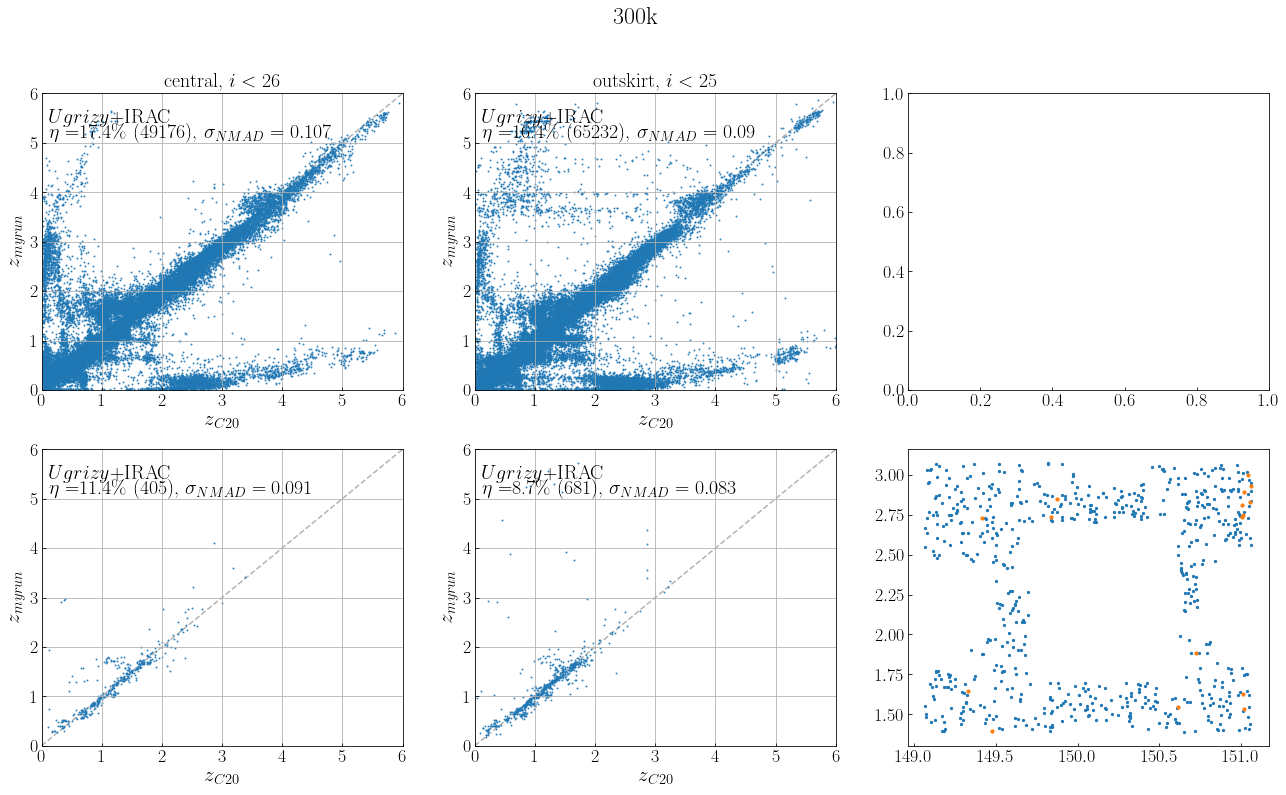

In [104]:
fig, axs = plt.subplots(2, 3, figsize = (22, 12))

name_tag = '_300k'
detect_limit = '_22.4'
cat_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'

print(cat_name)
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

# flags
flag_photoz = cat_output_c20added['flag_photoz']==1  # consistent photoz within C20 catalog
flag_filter = cat_output_c20added[flag_name_list[i]] 
flag_optical = cat_output_c20added['flag_optical'] 
flag_irac = cat_output_c20added['flag_irac'] 
flag_nir = cat_output_c20added['flag_nir'] 

# ra,dec limits
ra_min = 149.7
ra_max = 150.6
dec_min = 1.7
dec_max = 2.7

for i,selection in enumerate(['all','massive']):
    if selection == 'all':
        # all gals 
        cond_galtype = np.ones(len(cat_output_c20added)).astype(bool)
    else:
        # massive gals
        cond_galtype = (cat_output_c20added['MASS_MED_massrun']>massive_cut)
        
    for k,area_type in enumerate(['central', 'outskirt']):
        if area_type == 'central':
            cond_area = (cat_output_c20added['RA_1']>ra_min) & (cat_output_c20added['RA_1']<ra_max) & (cat_output_c20added['DEC_1']>dec_min) & (cat_output_c20added['DEC_1']<dec_max)
            cond_mag = cat_output_c20added['i']<26
        else:
            cond_area = (cat_output_c20added['RA_1']<ra_min) | (cat_output_c20added['RA_1']>ra_max) | (cat_output_c20added['DEC_1']<dec_min) | (cat_output_c20added['DEC_1']>dec_max)
            cond_mag = cat_output_c20added['i']<25
        
        if selection=='massive':
            cond = cond_galtype & cond_area & cond_mag & (flag_irac>1)
        else:
            cond = cond_galtype & cond_area & cond_mag
        cat_select = cat_output_c20added[cond]
    
        # plot
        im = axs[i][k].scatter(cat_select['lp_zPDF'], cat_select['Z_ML'],s=1,alpha=0.8)
        axs[i][k].plot([0,6],[0,6],'--k',alpha=0.3,zorder=0)
        axs[i][k].set_xlim([0,6])
        axs[i][k].set_ylim([0,6])
        axs[i][k].set_xlabel(r'$z_{C20}$',fontsize=21)
        axs[i][k].set_ylabel(r'$z_{myrun}$',fontsize=21)
        axs[i][k].grid()
        
        
        if area_type != 'central' and selection=='massive':  
            cond_outlier = (cat_select['Z_ML']-cat_select['lp_zPDF'])>0.5*(1+cat_select['lp_zPDF'])
            axs[1][2].scatter(cat_select['RA_1'],cat_select['DEC_1'],s=5)
            axs[1][2].scatter(cat_select[cond_outlier]['RA_1'],cat_select[cond_outlier]['DEC_1'],s=10)
            
        # print out outlier fraction
        outlier_factor = 0.15
        num_outliers_15 = len(cat_select[abs(cat_select['lp_zPDF']-cat_select['Z_ML'])>outlier_factor*(1+cat_select['lp_zPDF'])])
        deltaz = np.array(cat_select['Z_ML']-cat_select['lp_zPDF'])
        sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
        axs[i][k].annotate('$Ugrizy$+IRAC',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        axs[i][k].annotate('$\eta=$'+str(round(num_outliers_15/len(cat_select)*100,1))+'\% '+'('+str(len(cat_select))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
        
axs[0][0].set_title('central, $i<26$',fontsize=20)
axs[0][1].set_title('outskirt, $i<25$',fontsize=20)
plt.suptitle(name_tag.replace('_',''),fontsize=24)


##### outlier fraction and sigma as a function of redshift

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (16, 4), sharey=True)

cat_name = cat_output_no_nir_mass_name
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

z_sigma = []
z_list = np.arange(0.1,5.7,0.2)
for z in z_list:
    cat_z = cat_output_c20added[abs(cat_output_c20added['Z_ML']-z)<0.1]
    deltaz = np.array(cat_z['Z_ML']-cat_z ['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    z_sigma.append(sigma)
axs[0].plot(z_list, z_sigma )
axs[0].set_xlabel('$z$',fontsize=19)
axs[0].set_ylabel('$\sigma$',fontsize=19)

cat_name = cat_output_no_nir_mass_name
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

outlier_factor = 0.15
outlier_frac = []
z_list = np.arange(0.1,5.7,0.2)
for z in z_list:
    cat_z = cat_output_c20added[abs(cat_output_c20added['Z_ML']-z)<0.1]
    num_outliers = len(cat_z[abs(cat_z['lp_zPDF']-cat_z['Z_ML'])>outlier_factor*(1+cat_z['lp_zPDF'])])
    outlier_frac.append(round(num_outliers/len(cat_z),3))

axs[1].plot(z_list, outlier_frac )
axs[1].set_xlabel('$z$',fontsize=19)
axs[1].set_ylabel('outlier frac.',fontsize=19)

Text(0, 0.5, 'outlier frac.')

##### redshift comparison color coding by mag / mass

(0, 6)

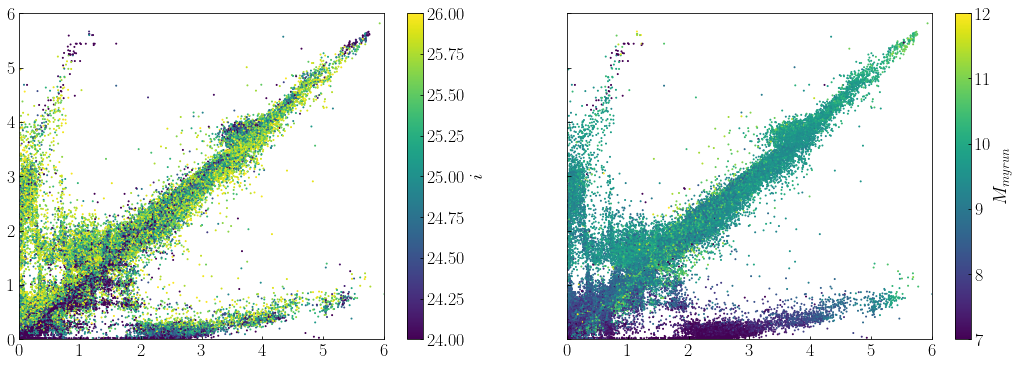

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (18, 6), sharey=True)

cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
im = axs[0].scatter(cat_output_c20added['lp_zPDF'],cat_output_c20added['Z_ML'],s=1,c=cat_output_c20added['i'],vmin=24,vmax=26)
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('$i$',fontsize=19)
axs[0].set_xlim([0,6])
axs[0].set_ylim([0,6])

im2 = axs[1].scatter(cat_output_c20added['lp_zPDF'],cat_output_c20added['Z_ML'],s=1,c=cat_output_c20added['MASS_MED_massrun'],vmin=7,vmax=12)
cbar = fig.colorbar(im2, ax=axs[1])
cbar.ax.set_ylabel('$M_{myrun}$',fontsize=19)
axs[1].set_xlim([0,6])
axs[1].set_ylim([0,6])

##### z-z plot in mass bins
for massive gals (10-10.5),(10.5-11),(11-12)

in central cosmos

3096
3618
1589


Text(0.5, 0.98, '$i<26$,optical+IRAC, Flag(IRAC)$>=1$, Central COSMOS')

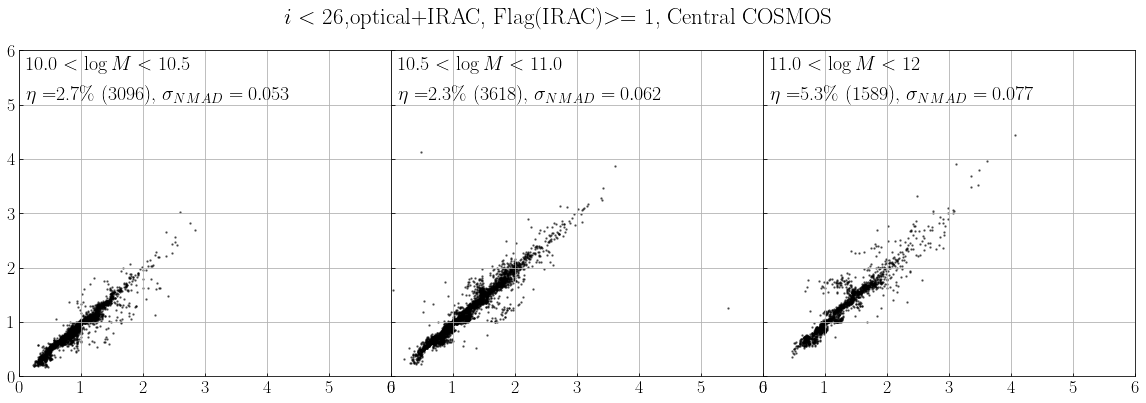

In [142]:
name_tag = '_08squdeg'
detect_limit = '_22.4'
cat_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
mass_min = [10.0,10.5,11.0]
mass_max = [10.5,11.0,12]

 # flags
flag_photoz = cat_output_c20added['flag_photoz']==1  # consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
flag_irac = cat_output_c20added['flag_irac'] 
flag_nir = cat_output_c20added['flag_nir'] 

# selection condition
cond_filters = (flag_optical>4) & (flag_irac>=1)

fig, axs = plt.subplots(1, 3, figsize = (20, 6), sharey=True)
for i in range(3):
    
    cond_mass = (cat_output_c20added['MASS_MED_massrun']>mass_min[i] ) & (cat_output_c20added['MASS_MED_massrun']<mass_max[i])
    cond = cond_filters & cond_mass # & flag_photoz
    print(len(cat_output_c20added[cond]))
    
    axs[i].scatter(cat_output_c20added[cond]['lp_zPDF'], cat_output_c20added[cond][z_keyname],s=2,c='k',alpha=0.5,cmap='Paired')
    axs[i].set_xlim([0,6])
    axs[i].set_ylim([0,6])
    axs[i].grid()
    
    # print out outlier fraction
    outlier_factor = 0.15
    num_outliers_15 = len(cat_output_c20added[cond][abs(cat_output_c20added[cond]['lp_zPDF']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF'])])
    deltaz = np.array(cat_output_c20added[cond]['Z_ML']-cat_output_c20added[cond]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    axs[i].annotate('$'+str(mass_min[i])+'<\log M<'+str(mass_max[i])+'$',xy=([0.02,0.94]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('$\eta=$'+str(round(num_outliers_15/len(cat_output_c20added[cond])*100,1))+'\% '+'('+str(len(flag_irac[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.suptitle('$i<26$,optical+IRAC, Flag(IRAC)$>=1$, Central COSMOS',fontsize=23)

##### z-z plots with different cuts

96583
56530
53616
11833


Text(0.5, 0.98, '$i<26$, optical+IRAC, Central COSMOS')

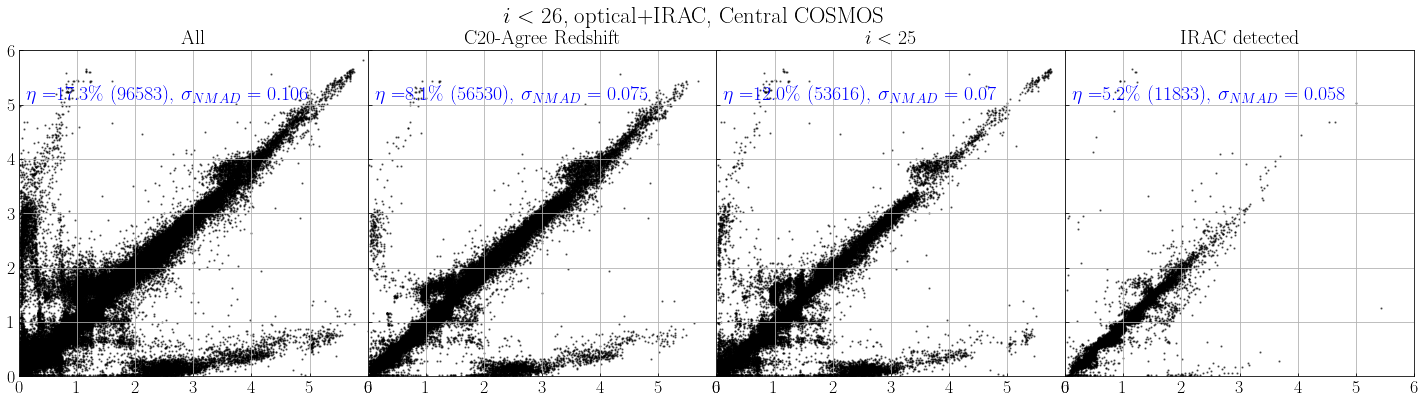

In [151]:
name_tag = '_08squdeg'
detect_limit = '_22.4'
cat_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

 # flags
flag_photoz = cat_output_c20added['flag_photoz']==1  # consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
flag_irac = cat_output_c20added['flag_irac'] 
flag_nir = cat_output_c20added['flag_nir'] 


fig, axs = plt.subplots(1, 4, figsize = (25, 6), sharey=True)
for i in range(4):
    
    if i==0:
        cond_cut = np.ones(len(cat_output_c20added)).astype(bool)
        title = 'All'
    elif i==1:
        cond_cut = flag_photoz
        title = 'C20-Agree Redshift'
    elif i==2:
        cond_cut = cat_output_c20added['i']<25
        title = '$i<25$'
    else:
        cond_cut = flag_irac>=1
        title = 'IRAC detected'
    
    cond = cond_cut 
    print(len(cat_output_c20added[cond]))
    
    axs[i].scatter(cat_output_c20added[cond]['lp_zPDF'], cat_output_c20added[cond][z_keyname],s=1.5,c='k',alpha=0.5,cmap='Paired')
    axs[i].set_title(title, fontsize=20)
    axs[i].set_xlim([0,6])
    axs[i].set_ylim([0,6])
    axs[i].grid()
    
    # print out outlier fraction
    outlier_factor = 0.15
    num_outliers_15 = len(cat_output_c20added[cond][abs(cat_output_c20added[cond]['lp_zPDF']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF'])])
    deltaz = np.array(cat_output_c20added[cond]['Z_ML']-cat_output_c20added[cond]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    axs[i].annotate('$\eta=$'+str(round(num_outliers_15/len(cat_output_c20added[cond])*100,1))+'\% '+'('+str(len(flag_irac[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='b')
    
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.suptitle('$i<26$, optical+IRAC, Central COSMOS',fontsize=23)


#### check matching with SHIRAZ catalog
for massive gals

In [495]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from astropy.io import fits
import aplpy

In [12]:
## load shiraz catalog
cat_shiraz = Table.read('/Volumes/LejaySSD/SHIRAZ_catalogs/COSMOS_scosmos_ext_CH1_newfluxes_errmod.fits')
cond_ch1_shiraz = ( (cat_shiraz['MAG_AUTO'] > 0.) & (cat_shiraz['MAG_AUTO'] < 50) & (cat_shiraz['MAGERR_AUTO'] > 0.) & (cat_shiraz['MAGERR_AUTO'] < 0.5) )

# geometry cut (central cosmos)
cat_shiraz_select = cat_shiraz[cond_ch1_shiraz]
cat_shiraz_select = cat_shiraz_select[cat_shiraz_select['ALPHA_J2000']>149.7]
cat_shiraz_select = cat_shiraz_select[cat_shiraz_select['ALPHA_J2000']<150.3]
cat_shiraz_select = cat_shiraz_select[cat_shiraz_select['DELTA_J2000']>2.0]
cat_shiraz_select = cat_shiraz_select[cat_shiraz_select['DELTA_J2000']<2.5]

In [430]:
# check massives (in optical+irac phot catalog)
cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

# add flag_irac column
cond_ch1 = ( (cat_output_c20added['MAG_AUTO_CH1_CORR'] > 0.) & (cat_output_c20added['MAG_AUTO_CH1_CORR'] < 50.) & (cat_output_c20added['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_output_c20added['MAGERR_AUTO_CH1_CORR'] < 0.5) )
cond_ch2 = ( (cat_output_c20added['MAG_AUTO_CH2_CORR'] > 0.) & (cat_output_c20added['MAG_AUTO_CH2_CORR'] < 50.) & (cat_output_c20added['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_output_c20added['MAGERR_AUTO_CH2_CORR'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int)
flag_irac_col = Column(name='flag_irac',data=flag_irac)
if 'flag_irac' not in cat_output_c20added.keys():
    cat_output_c20added.add_column(flag_irac_col)

# condition
massive_cut=11.2
# cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut) & (cat_matched['lp_mass_med']<(massive_cut-0.5))  # fake massive
cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)  # my massive

massive_gals_selected = cat_output_c20added[cond]
massive_gals_selected.write('lp_massive_gal_check.fits',overwrite=True)

# cat_output_c20added[cond]['ID_1','i','MAG_AUTO_CH1_CORR','MAGERR_AUTO_CH1_CORR','MAG_AUTO_CH2_CORR','MAGERR_AUTO_CH2_CORR','flag_irac'].show_in_notebook()

/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

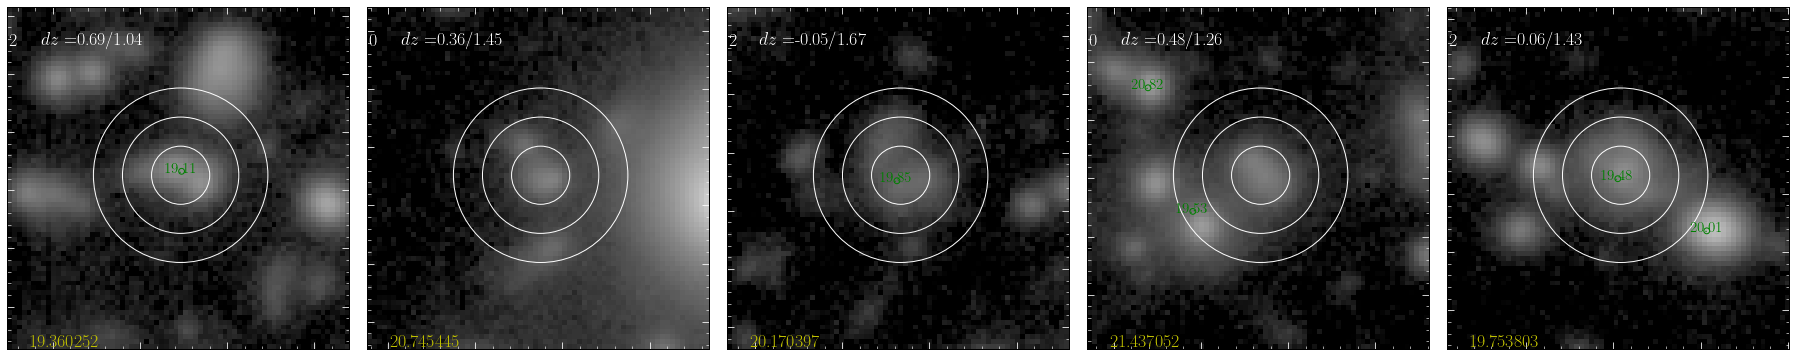

In [531]:
fig = plt.figure(figsize=(25, 5))

massive_gals_checked = Table.read('lp_massive_gal_check/lp_massive_gal_check_matched.fits')
for i, gal in enumerate(massive_gals_checked[15:20]):
    row = i // 5
    col = i % 5
    
    # plot nearby shiraz galaxies
    cat_shiraz_neighbor = cat_shiraz_select[abs(cat_shiraz_select['ALPHA_J2000']-gal['RA'])<5./3600]
    cat_shiraz_neighbor = cat_shiraz_neighbor[abs(cat_shiraz_neighbor['DELTA_J2000']-gal['DEC'])<5./3600]
    
    # record separation and magnitude difference (between C20 mag and SHIRAZ mag of the closest match)
    coord_gal = SkyCoord(SkyCoord(gal['RA'] * u.deg, gal['DEC'] * u.deg))
    coord_shiraz = SkyCoord(cat_shiraz_neighbor['ALPHA_J2000']*u.deg, cat_shiraz_neighbor['DELTA_J2000']*u.deg)
    if len(cat_shiraz_neighbor)>0:
        idx, sep2d, dis3d = match_coordinates_sky(coord_gal, coord_shiraz)
        sep_list.append(sep2d.value[0]*3600)
        mag_diff_list.append(cat_shiraz_neighbor[idx]['MAG_AUTO']-gal['IRAC_CH1_MAG_1'])
        if abs(gal['Z_BEST'] - gal['lp_zPDF'])< 0.15*(1+gal['lp_zPDF']):
            photoz_flag.append(0)
        else:
            photoz_flag.append(1)
    
    # plot
    gc = aplpy.FITSFigure('lp_massive_gal_check/cutout_'+str(gal['ID'])+'.fits',figure=fig,subplot=[0.1+col*0.2, 0.1+row*0.1, 0.19, 0.95])
    gc.show_grayscale(stretch='log',vmin=2,vmax=5e3)
    gc.hide_yaxis_label()
    gc.hide_ytick_labels()
    gc.hide_xaxis_label()
    gc.hide_xtick_labels()

    for r in [1,2,3]:
        gc.show_circles(gal['RA'],gal['DEC'],radius=r/3600.,color='white')
        
    for gal_shiraz in cat_shiraz_neighbor:
        gc.add_label(gal_shiraz['ALPHA_J2000'],gal_shiraz['DELTA_J2000']+0.1/3600,str(round(gal_shiraz['MAG_AUTO'],2)),fontsize=15,color='g')
            
    gc.show_circles(cat_shiraz_neighbor['ALPHA_J2000'], cat_shiraz_neighbor['DELTA_J2000'],radius=0.1/3600.,color='g')
    gc.add_label(0.017,0.9,gal['flag_irac'],relative=True,fontsize=18,color='w')
    gc.add_label(0.25,0.9,'$dz=$'+str(round(gal['Z_BEST'] - gal['lp_zPDF'],2))+'/'+str(round(gal['lp_zPDF'],2)),relative=True,fontsize=18,color='w')
    gc.add_label(0.17,0.02, gal['IRAC_CH1_MAG_1'],relative=True,fontsize=18,color='y')

# plt.tight_layout(w_pad=-2,h_pad=1)
# plt.savefig('/Users/lejay/Desktop/shiraz_match_check.pdf')   

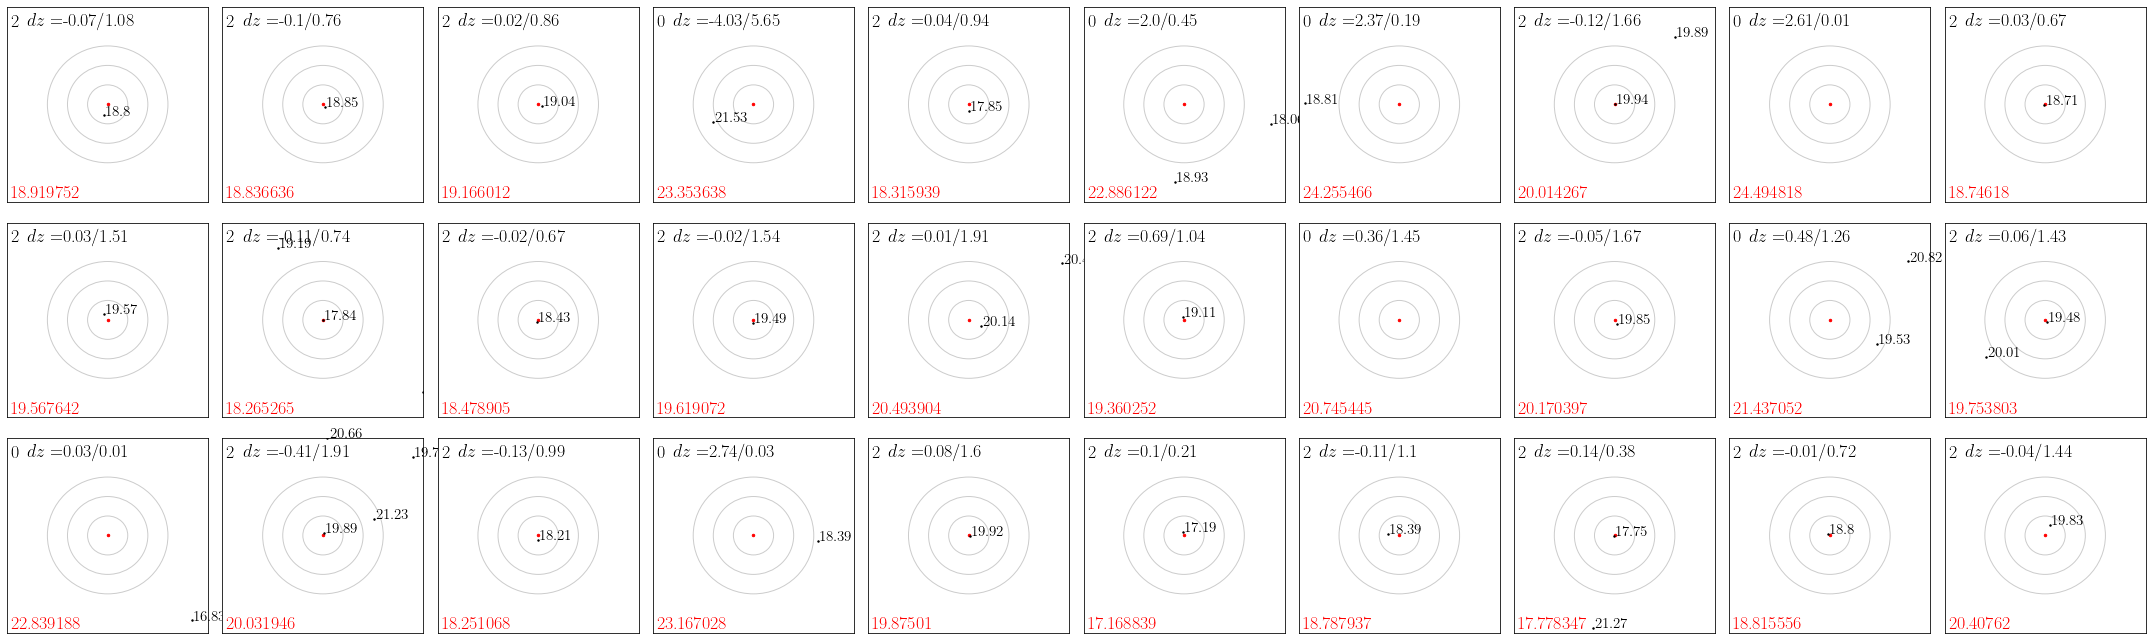

In [435]:
fig, axs = plt.subplots(3, 10, figsize = (30,9))

sep_list = []
mag_diff_list = [] 
photoz_flag = []
for i, gal in enumerate(massive_gals_checked[:30]):
    row = i // 10
    col = i % 10
    
    # plot nearby shiraz galaxies
    cat_shiraz_neighbor = cat_shiraz_select[abs(cat_shiraz_select['ALPHA_J2000']-gal['RA'])<5./3600]
    cat_shiraz_neighbor = cat_shiraz_neighbor[abs(cat_shiraz_neighbor['DELTA_J2000']-gal['DEC'])<5./3600]
    
    # record separation and magnitude difference (between C20 mag and SHIRAZ mag of the closest match)
    coord_gal = SkyCoord(SkyCoord(gal['RA'] * u.deg, gal['DEC'] * u.deg))
    coord_shiraz = SkyCoord(cat_shiraz_neighbor['ALPHA_J2000']*u.deg, cat_shiraz_neighbor['DELTA_J2000']*u.deg)
    if len(cat_shiraz_neighbor)>0:
        idx, sep2d, dis3d = match_coordinates_sky(coord_gal, coord_shiraz)
        sep_list.append(sep2d.value[0]*3600)
        mag_diff_list.append(cat_shiraz_neighbor[idx]['MAG_AUTO']-gal['IRAC_CH1_MAG_1'])
        if abs(gal['Z_BEST'] - gal['lp_zPDF'])< 0.15*(1+gal['lp_zPDF']):
            photoz_flag.append(0)
        else:
            photoz_flag.append(1)
    
    # show the chi2 image as background
    
    
    # plot
    axs[row][col].scatter(gal['RA'],gal['DEC'],s=6,c='r')
    for r in [1,2,3]:
        circle = plt.Circle((gal['RA'],gal['DEC']),r/3600.,fill=False,alpha=0.2)
        axs[row][col].add_patch(circle)
        
    for gal_shiraz in cat_shiraz_neighbor:
        axs[row][col].annotate(round(gal_shiraz['MAG_AUTO'],2),xy=([gal_shiraz['ALPHA_J2000']+0.1/3600,gal_shiraz['DELTA_J2000']]),xycoords='data',fontsize=15,color='k')
            
    axs[row][col].scatter(cat_shiraz_neighbor['ALPHA_J2000'], cat_shiraz_neighbor['DELTA_J2000'],s=2,c='k',alpha=1)
    axs[row][col].annotate(gal['flag_irac'],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=18,color='k')
    axs[row][col].annotate('$dz=$'+str(round(gal['Z_BEST'] - gal['lp_zPDF'],2))+'/'+str(round(gal['lp_zPDF'],2)),xy=([0.1,0.9]),xycoords='axes fraction',fontsize=18,color='k')
    axs[row][col].annotate(gal['IRAC_CH1_MAG_1'],xy=([0.02,0.02]),xycoords='axes fraction',fontsize=18,color='r')
    axs[row][col].set_xlim([gal['RA']-5/3600.,gal['RA']+5/3600.])
    axs[row][col].set_ylim([gal['DEC']-5/3600.,gal['DEC']+5/3600.])
    axs[row][col].get_xaxis().set_visible(False)
    axs[row][col].get_yaxis().set_visible(False)

plt.tight_layout(w_pad=-2,h_pad=1)
plt.savefig('/Users/lejay/Desktop/shiraz_match_check.pdf')

### mass comparison plots

In [28]:
massive_cut = 11.2

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonirirac_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_noirac_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_allphot_il_nz_prior_nolimit_formassc20added.fits 199852


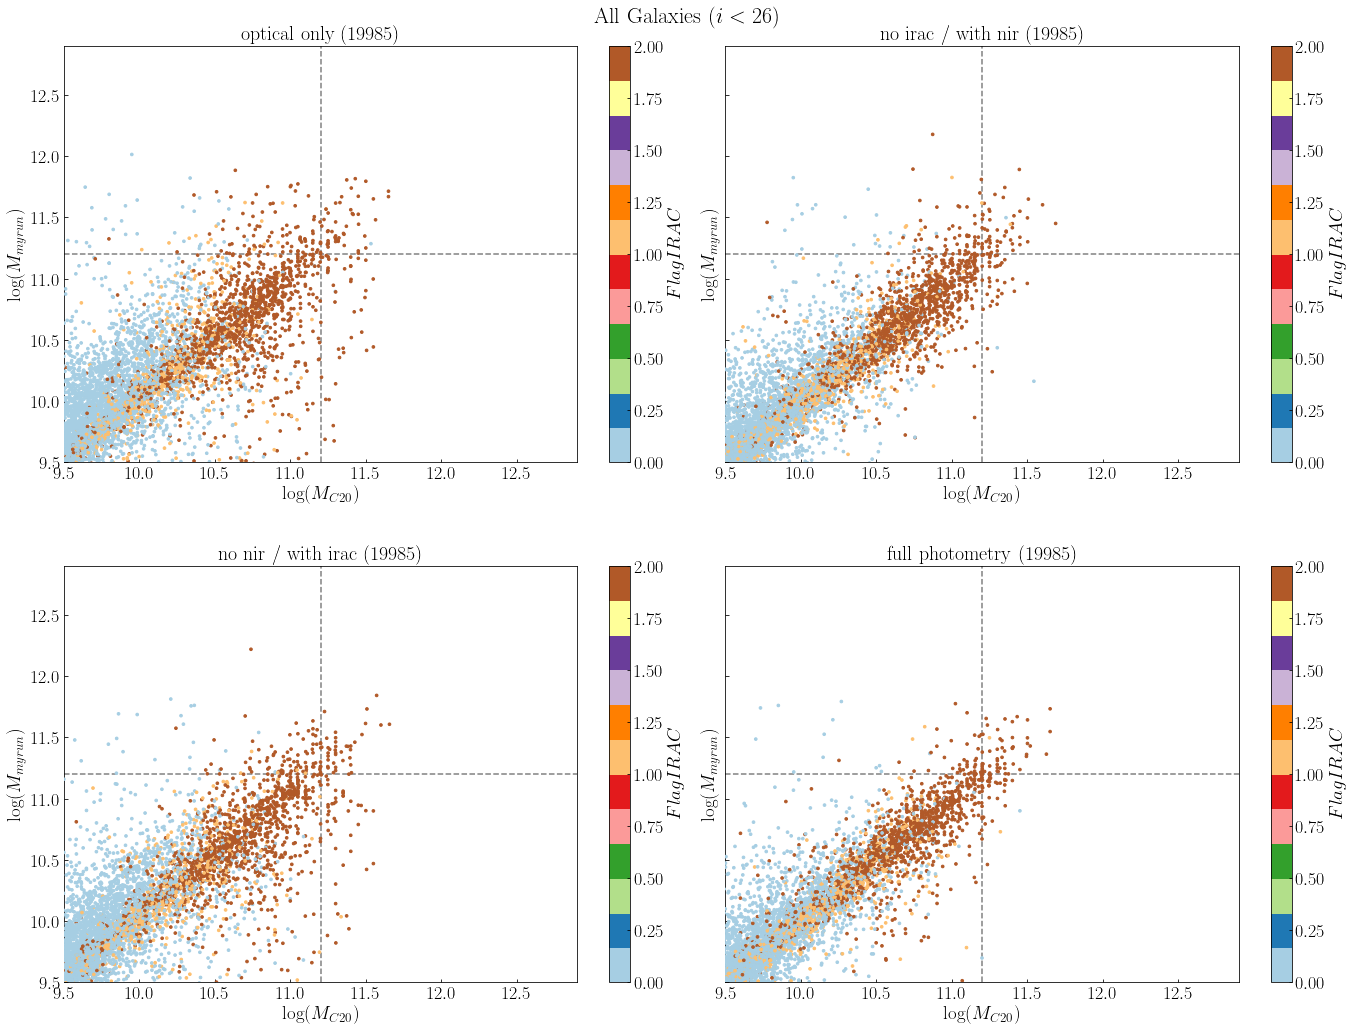

In [30]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/lejay/Desktop/lephare_mass_comparison.pdf")
fig, axs = plt.subplots(2, 2, figsize = (20, 15),sharey=True)
for i,cat_name in enumerate(cat_names):
    row = i // 2; col = i % 2
    cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
    print(cat_name.replace('.fits','c20added.fits'),len(cat_output_c20added))
    
    select_ids = np.random.choice(np.arange(len(cat_output_c20added)), size=int(len(cat_output_c20added)/10), replace=False)
    cat_output_c20added = cat_output_c20added[select_ids]
    
    # conditions
    cond = np.ones(len(cat_output_c20added)).astype(bool)
    fig_title = 'All Galaxies ($i<26$)'
    cond = cond # & flag_photoz
    
    ### plot with errorbars
    x = cat_output_c20added[cond]['lp_mass_med']
    y = cat_output_c20added[cond]['MASS_MED_massrun']
    # x_err = [x-cat_output_c20added[cond]['lp_mass_med_min68'],cat_output_c20added[cond]['lp_mass_med_max68']-x]
    # y_err = [y-cat_output_c20added[cond]['MASS_INF'],cat_output_c20added[cond]['MASS_SUP']-y]
    # axs[row][col].errorbar(x, y,yerr=y_err,xerr=x_err,fmt='.',zorder=20,color='k',alpha=0.02) 
    
    ### just data points
    im = axs[row][col].scatter(x,y,s=7,c=cat_output_c20added[cond]['flag_irac'],vmin=0,vmax=2,cmap='Paired',zorder=10)
    
    cbar = fig.colorbar(im, ax=axs[row][col])
    cbar.ax.set_ylabel(r'$Flag IRAC$',fontsize=19)
    axs[row][col].set_xlim([9.5,12.9])
    axs[row][col].set_ylim([9.5,12.9])
    axs[row][col].set_xlabel(r'$\log(M_{C20})$',fontsize=19)
    axs[row][col].set_ylabel(r'$\log(M_{myrun})$',fontsize=19)
    axs[row][col].set_title(filter_selections[i]+' ('+str(len(cat_output_c20added[cond]))+')', fontsize=20)
    axs[row][col].axvline(x=11.2,ymin=0,ymax=1,color='k',ls='--',alpha=0.5)
    axs[row][col].axhline(y=11.2,xmin=0,xmax=1,color='k',ls='--',alpha=0.5)
    
    #
    # bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # for quad in [(-1,-1),(-1,1),(1,-1),(1,1)]:
    #     quad_x = quad[0]
    #     quad_y = quad[1]
    #     mass_cut_cond_x =  quad_x*cat_output_c20added['lp_mass_med']>quad_x*11.2
    #     mass_cut_cond_y =  quad_y*cat_output_c20added['MASS_MED_massrun']>quad_y*11.2
    #     if '_nonir_' not in cat_name:
    #         axs[row][col].text(11.2+quad_x*1.4, 11.2+quad_y*1.5, str(len(cat_output_c20added[cond & mass_cut_cond_x & mass_cut_cond_y])), ha="center", va="center", size=18, bbox=bbox_props,zorder=0)
    #     else:
    #         num_all = len(cat_output_c20added[cond & mass_cut_cond_x & mass_cut_cond_y])
    #         num_flag_irac1 = len(cat_output_c20added[cond & mass_cut_cond_x & mass_cut_cond_y & (flag_irac>=1)])
    #         axs[row][col].text(11.2+quad_x*1.4, 11.2+quad_y*1.5, str(num_flag_irac1)+'/'+str(num_all), ha="center", va="center", size=18, bbox=bbox_props,zorder=0)
    
plt.suptitle(fig_title,fontsize=22)
plt.tight_layout(pad=4, w_pad=0)
pdf.savefig( fig )
pdf.close()

In [26]:
for i,cat_name in enumerate(cat_names):
    row = i // 2; col = i % 2
    cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
    print(cat_name.replace('.fits','c20added.fits'),len(cat_output_c20added))
    
    # select_ids = np.random.choice(np.arange(len(cat_output_c20added)), size=int(len(cat_output_c20added)/10), replace=False)
    # cat_output_c20added = cat_output_c20added[select_ids]
    
    # conditions
    cond = np.ones(len(cat_output_c20added)).astype(bool)
    fig_title = 'All Galaxies ($i<26$)'
    cond = cond # & flag_photoz
    
    ### plot with errorbars
    masses = np.array(cat_output_c20added[cond]['MASS_MED_massrun'])
    redshifts = np.array(cat_output_c20added[cond]['Z_ML'])
    if i==0:
        mass_compare_arr = masses
        redshift_compare_arr = redshifts
    else:
        mass_compare_arr = np.vstack([mass_compare_arr,masses])
        redshift_compare_arr = np.vstack([redshift_compare_arr,redshifts])

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonirirac_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_noirac_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits 199852
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_allphot_il_nz_prior_nolimit_formassc20added.fits 199852


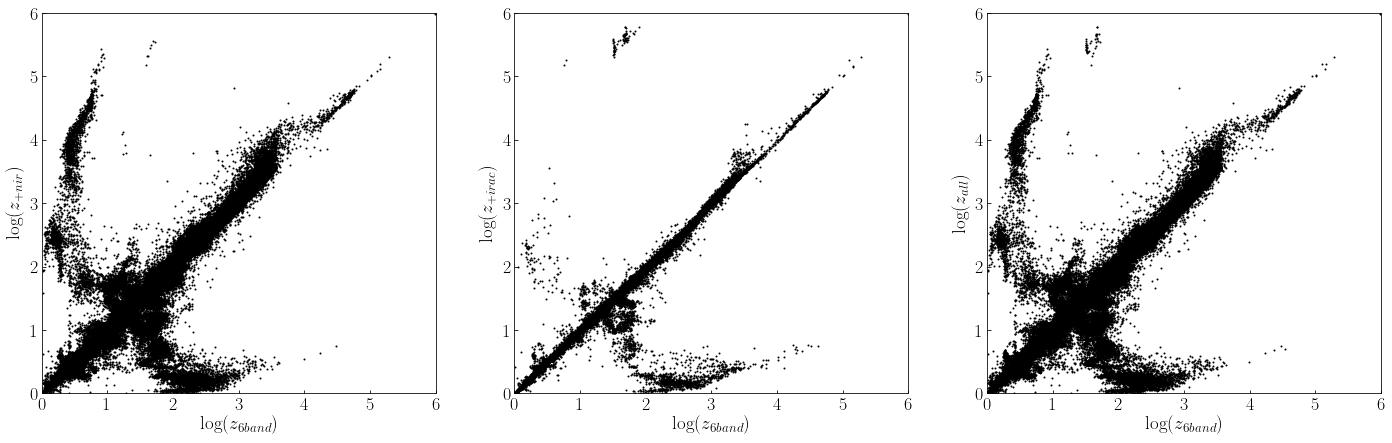

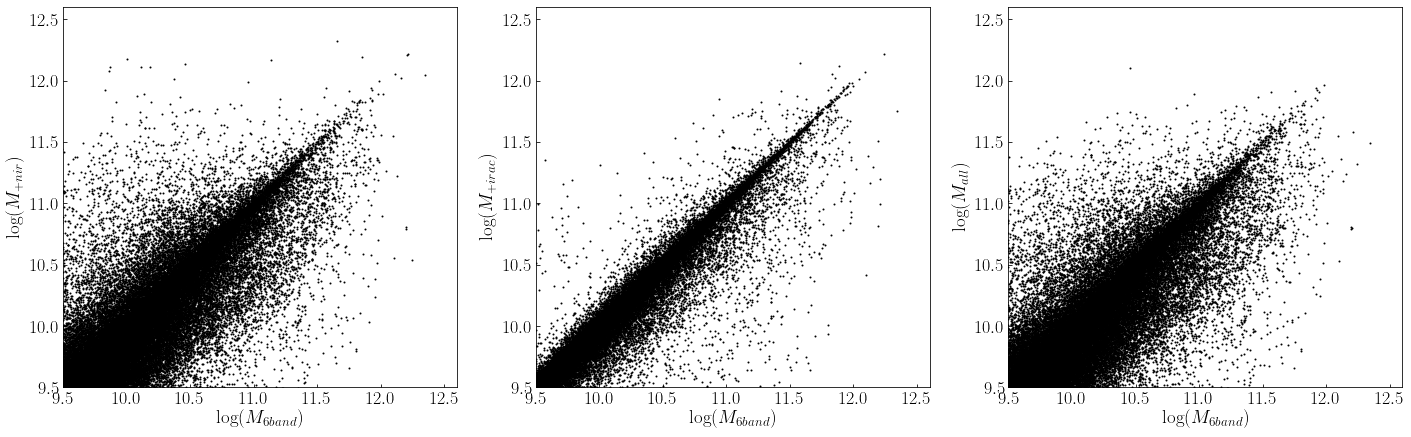

In [34]:
# 0 - nonirirac
# 1 - noirac
# 2 - nonir
# 3 - allphot

fig, axs = plt.subplots(1, 3, figsize = (24, 7))
phot_config = ['6band','+nir','+irac','all']
for k in range(3):
    axs[k].scatter(redshift_compare_arr[0],redshift_compare_arr[k+1],s=1,color='k')
    axs[k].set_xlim([0,6])
    axs[k].set_ylim([0,6])
    
    axs[k].set_xlabel(r'$\log(z_{6band})$',fontsize=19)
    axs[k].set_ylabel(r'$\log(z_{'+phot_config[k+1]+'})$',fontsize=19)

fig, axs = plt.subplots(1, 3, figsize = (24, 7))
phot_config = ['6band','+nir','+irac','all']
for k in range(3):
    axs[k].scatter(mass_compare_arr[0],mass_compare_arr[k+1],s=1,color='k')
    axs[k].set_xlim([9.5,12.6])
    axs[k].set_ylim([9.5,12.6])
    
    axs[k].set_xlabel(r'$\log(M_{6band})$',fontsize=19)
    axs[k].set_ylabel(r'$\log(M_{'+phot_config[k+1]+'})$',fontsize=19)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_22.4_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_22.4_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_22.4_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_22.4_formassc20added.fits


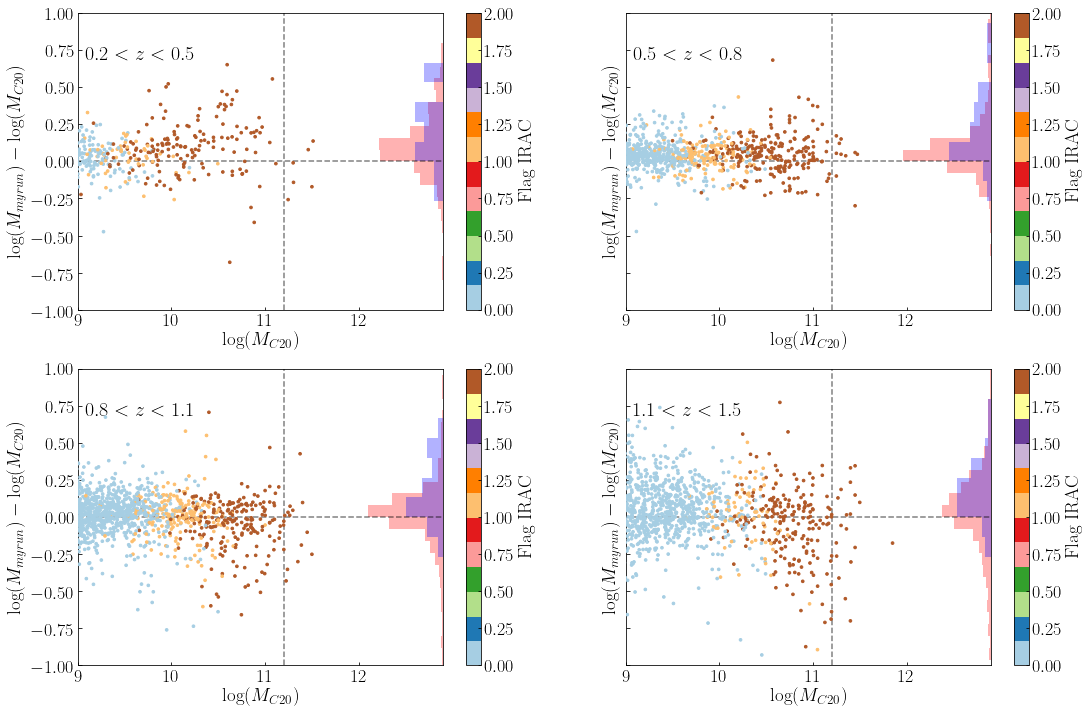

In [56]:
#pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/lejay/Desktop/lephare_mass_comparison.pdf")
fig, axs = plt.subplots(2, 2, figsize = (18, 12),sharey=True)
for i,z_range in enumerate([(0.2,0.5),(0.5,0.8),(0.8,1.1),(1.1,1.5)]):
    row = i // 2; col = i % 2
    cat_name = cat_output_no_nir_mass_name
    cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
    cat_output_c20added = cat_output_c20added[cat_output_c20added['Z_ML']>z_range[0]]
    cat_output_c20added = cat_output_c20added[cat_output_c20added['Z_ML']<z_range[1]]
    cat_output_c20added = cat_output_c20added[abs(cat_output_c20added['Z_ML'] - cat_output_c20added['Z_BEST'])<0.05]
    print(cat_name.replace('.fits','c20added.fits'))
    
    select_ids = np.random.choice(np.arange(len(cat_output_c20added)), size=int(len(cat_output_c20added)/5), replace=False)
    cat_output_c20added = cat_output_c20added[select_ids]
    
    # conditions
    cond = np.ones(len(cat_output_c20added)).astype(bool)
    flag_photoz = cat_output_c20added['flag_photoz']==1  
    cond_photoz_match = abs(cat_output_c20added['Z_ML'] - cat_output_c20added['lp_zPDF'])<0.15*(1+cat_output_c20added['lp_zPDF'])
    fig_title = 'All Galaxies ($i<26$)'
    cond = cond & flag_photoz & cond_photoz_match
    
    # plot
    x = cat_output_c20added[cond]['lp_mass_med']
    y = cat_output_c20added[cond]['MASS_MED_massrun'] - cat_output_c20added[cond]['lp_mass_med']
    im = axs[row][col].scatter(x,y,s=7,c=cat_output_c20added[cond]['flag_irac'],vmin=0,vmax=2,cmap='Paired',zorder=10)
    
    # histograms
    xmax = 12.9
    cat_z_sat_mass = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>9.5]
    axs[row][col].hist(cat_z_sat_mass['MASS_MED_massrun']-cat_z_sat_mass['lp_mass_med'],bins=50,range=(-2,2),orientation='horizontal',bottom=xmax, weights=-3/len(cat_z_sat_mass)*np.ones(len(cat_z_sat_mass)),color='r',alpha=0.3)
    cat_z_cen_mass = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>massive_cut]
    if len(cat_z_cen_mass)>0:
        axs[row][col].hist(cat_z_cen_mass['MASS_MED_massrun']-cat_z_cen_mass['lp_mass_med'],bins=30,range=(-2,2),orientation='horizontal',bottom=xmax, weights=-1.2/len(cat_z_cen_mass)*np.ones(len(cat_z_cen_mass)),color='b',alpha=0.3)
    
    axs[row][col].set_xlim([9,xmax])
    axs[row][col].set_ylim([-1,1])
    axs[row][col].set_xlabel(r'$\log(M_{C20})$',fontsize=19)
    axs[row][col].set_ylabel(r'$\log(M_{myrun})-\log(M_{C20})$',fontsize=19)
    axs[row][col].axvline(x=11.2,ymin=0,ymax=1,color='k',ls='--',alpha=0.5)
    axs[row][col].axhline(y=0,xmin=0,xmax=1,color='k',ls='--',alpha=0.5)
    axs[row][col].annotate('$'+str(z_range[0])+'<z<'+str(z_range[1])+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k',zorder=0)
    
    cbar = fig.colorbar(im, ax=axs[row][col])
    cbar.ax.set_ylabel('Flag IRAC',fontsize=19)
    
# plt.suptitle(fig_title,fontsize=22)
# plt.tight_layout(pad=4, w_pad=0)
# pdf.savefig( fig )
# pdf.close()

#### mass vs. redshift comparison plots

all
massive
massive_c20


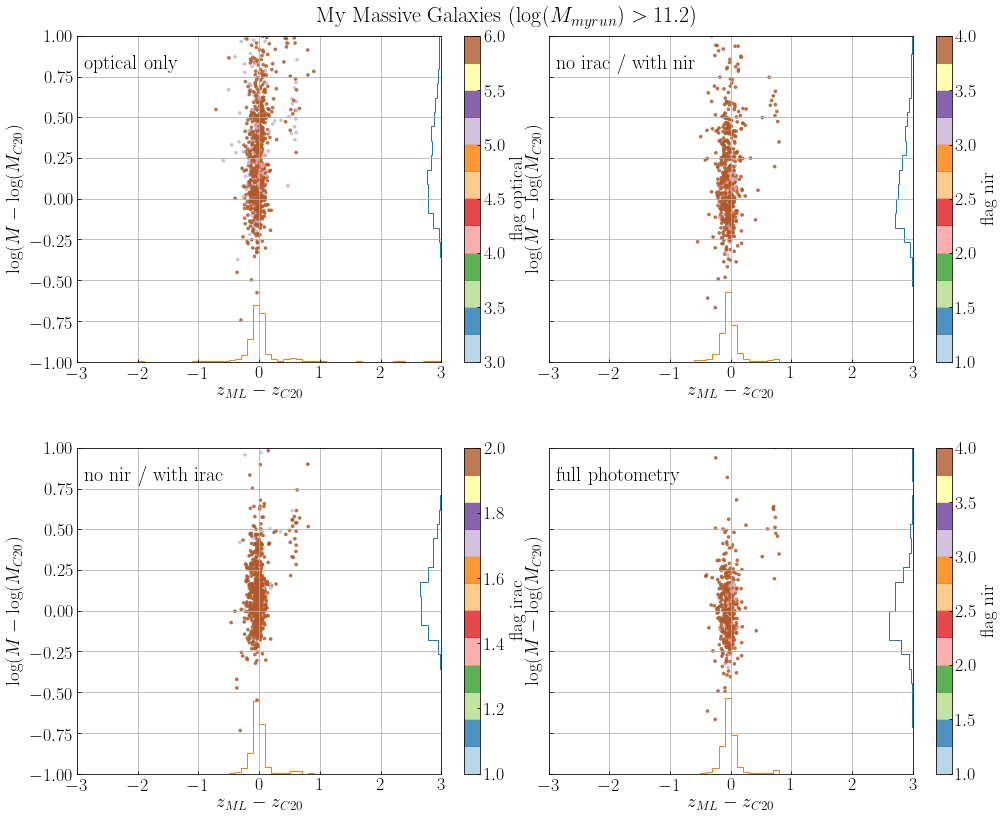

In [36]:
pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/lejay/Desktop/lephare_mass_photoz_diff_comparison.pdf")
massive_cut=11.2

c20_type = 'ez' # ez or lp
if c20_type == 'lp':
    c20_zkeyname = 'lp_zPDF'
    c20_mkeyname = 'lp_mass_med'
else:
    c20_zkeyname = 'ez_z500'
    c20_mkeyname = 'log_ez_mass_p500'
    
for selection in ['all','massive','massive_c20']:
    print(selection)
    fig, axs = plt.subplots(2, 2, figsize = (15, 12),sharey=True)
    for i,cat_name in enumerate(cat_names):
        row = i // 2; col = i % 2
        cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
        cat_output_c20added = cat_output_c20added[cat_output_c20added[c20_zkeyname]>0]
        
        # flags
        flag_photoz = cat_output_c20added['flag_photoz']==1  
        flag_filter = cat_output_c20added[flag_name_list[i]] 
        flag_optical = cat_output_c20added['flag_optical'] 
        flag_irac = cat_output_c20added['flag_irac'] 
        flag_nir = cat_output_c20added['flag_nir'] 
        
        # only show galaxies with good photo
        if '_nonirirac_' in cat_name:
            cond_filters = (flag_optical>2)
        elif '_nonir_' in cat_name:
            cond_filters = (flag_optical>2) & (flag_irac>=1)
        elif '_noirac_' in cat_name:
            cond_filters = (flag_optical>2) & (flag_nir>=1)
        else:
            cond_filters = (flag_optical>2) & (flag_irac>=1) & (flag_nir>=1)
        
        # select subsample
        if selection == 'all':
            cond = np.ones(len(cat_output_c20added)).astype(bool)
            fig_title = 'All Galaxies ($i<26$)'
        elif selection == 'massive_c20':
            cond = (cat_output_c20added[c20_mkeyname]>massive_cut)
            fig_title = 'Truly Massive Galaxies ($\log(M_{C20})>'+str(massive_cut)+'$)'  
        elif selection == 'massive':
            cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)
            fig_title = 'My Massive Galaxies ($\log(M_{myrun})>'+str(massive_cut)+'$)'
        else:
            raise NameError('wrong name')
        
        # COSMOS consistent photoz objects only
        cond = cond & flag_photoz & cond_filters
        
        x = cat_output_c20added[cond]['Z_ML']-cat_output_c20added[cond][c20_zkeyname]
        y = cat_output_c20added[cond]['MASS_MED_massrun']-cat_output_c20added[cond][c20_mkeyname]
        im = axs[row][col].scatter(x,y,s=7,c=flag_filter[cond],alpha=0.8,cmap='Paired')
        axs[row][col].set_xlim([-3,3])
        if 'massive' in selection:
            axs[row][col].set_ylim([-1,1])
        else:
            axs[row][col].set_ylim([-4,4])
            
        axs[row][col].set_xlabel(r'$z_{ML}- z_{C20}$',fontsize=19)
        axs[row][col].set_ylabel(r'$\log(M - \log(M_{C20})$',fontsize=19)
        axs[row][col].grid()
        axs[row][col].annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    
        cbar = fig.colorbar(im, ax=axs[row][col])
        cbar.ax.set_ylabel(flag_name_list[i].replace('_',' '),fontsize=19)
        
        axs[row][col].hist(y,bins=90,range=(-4,4),orientation='horizontal',weights=-2*np.ones(len(y))/len(y),bottom=3,histtype='step')
        if 'massive' in selection:
            axs[row][col].hist(x,bins=60,range=(-3,3),orientation='vertical',weights=1*np.ones(len(x))/len(x),bottom=-1,histtype='step')
        else:
            axs[row][col].hist(x,bins=40,range=(-3,3),orientation='vertical',weights=2*np.ones(len(x))/len(x),bottom=-4,histtype='step')
    
    
    plt.suptitle(fig_title,fontsize=22)
    plt.tight_layout(pad=4, w_pad=-1)
    pdf.savefig( fig )
pdf.close()

In [39]:
# dM vs. dz plot in redshift bins

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
massive_cut = 11.2

cat_name = cat_output_no_nir_mass_name
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
flag_photoz = cat_output_c20added['flag_photoz']==1 
cat_output_c20added_massive = cat_output_c20added[flag_photoz & (cat_output_c20added['MASS_MED_massrun']>massive_cut)]

for i,z_range in enumerate([(0.2,0.5),(0.5,0.8),(0.8,1.1),(1.1,1.5)]):
    row = i // 2; col = i % 2
    cat_output_c20added_z = cat_output_c20added_massive[cat_output_c20added_massive['Z_ML']>z_range[0]]
    cat_output_c20added_z = cat_output_c20added_z[cat_output_c20added_z['Z_ML']<z_range[1]]
    print(cat_name.replace('.fits','c20added.fits'))
    
    flag_irac = cat_output_c20added_z['flag_irac']
    flag_optical = cat_output_c20added_z['flag_optical'] 
    cond = (flag_optical>1) & (flag_irac>=1)
    
    axs[row][col].annotate('$'+str(z_range[0])+'<z<'+str(z_range[1])+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k',zorder=0)
    x = cat_output_c20added_z[cond]['Z_ML']-cat_output_c20added_z[cond]['lp_zPDF']
    y = cat_output_c20added_z[cond]['MASS_MED_massrun']-cat_output_c20added_z[cond]['lp_mass_med']
    im = axs[row][col].scatter(x,y,s=7,c=flag_irac[cond],alpha=1,cmap='Paired')
    
    axs[row][col].set_xlabel('$z_{ML} - z_{C20}$',fontsize=19)
    axs[row][col].set_ylabel('$M - M_{C20}$',fontsize=19)
    # axs[row][col].set_xlim([-1,1])
    # axs[row][col].set_ylim([-1,1])
    axs[row][col].grid()
    cbar = fig.colorbar(im, ax=axs[row][col])
    cbar.ax.set_ylabel('flag irac',fontsize=19)
    
    # histograms
    axs[row][col].hist(y,bins=30,range=(-1,1),orientation='horizontal',weights=-0.05*np.ones(len(y)),bottom=1,histtype='step')
    axs[row][col].hist(x,bins=30,range=(-1,1),orientation='vertical',weights=0.05*np.ones(len(x)),bottom=-1,histtype='step')

plt.suptitle('Central COSMOS 0.8 squdeg, Optical+IRAC',fontsize=23)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits


Text(0.5, 0.98, 'Central COSMOS 0.8 squdeg, Optical+IRAC')

In [10]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

median dM's
optical only dM=0.07 , massive dM=0.37
median dM's
no irac / with nir dM=-0.0 , massive dM=0.18
median dM's
no nir / with irac dM=0.03 , massive dM=0.18
median dM's
full photometry dM=-0.01 , massive dM=0.09


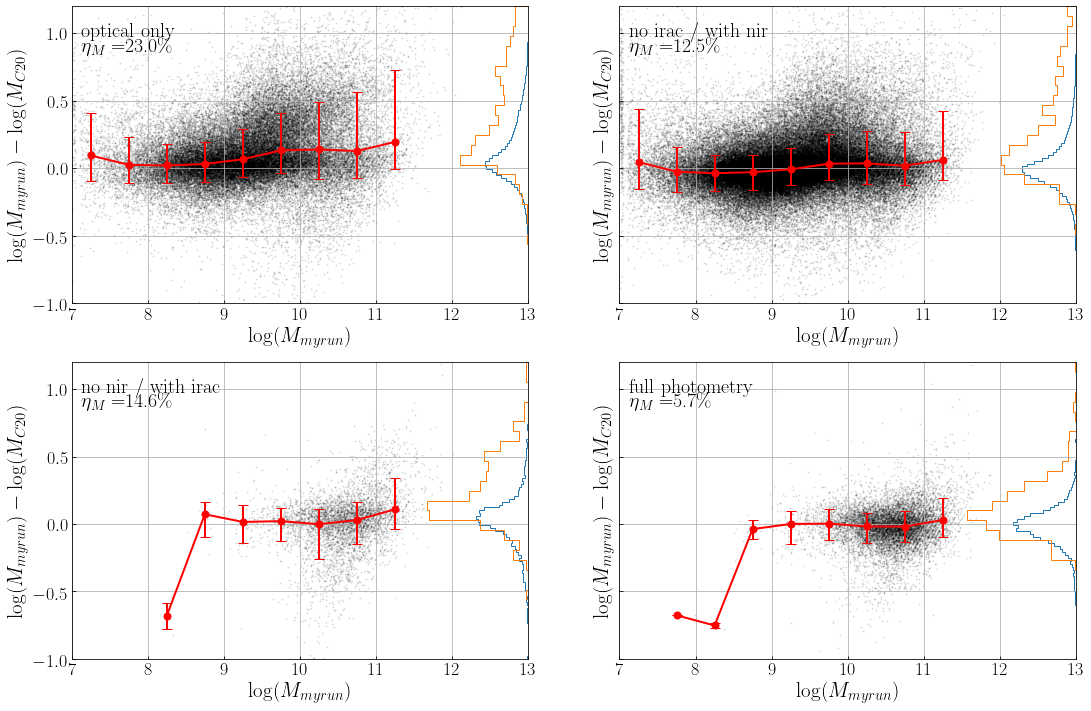

In [51]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/lejay/Desktop/lephare_mass_photoz_comparison.pdf")
fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
for i,cat_name in enumerate(cat_names):
    row = i // 2; col = i % 2
    cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
    flag_photoz = cat_output_c20added['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
        
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_output_c20added['Z_ML'] - cat_output_c20added['lp_zPDF'])<0.15*(1+cat_output_c20added['lp_zPDF'])
    flag_optical = cat_output_c20added['flag_optical'] 
    flag_irac = cat_output_c20added['flag_irac'] 
    flag_nir = cat_output_c20added['flag_nir'] 
    # only show galaxies with good photo
    if '_nonirirac_' in cat_name:
        cond_filters = (flag_optical>3)
    elif '_nonir_' in cat_name:
        cond_filters = (flag_optical>3) & (flag_irac>1)
    elif '_noirac_' in cat_name:
        cond_filters = (flag_optical>3) & (flag_nir>=1)
    else:
        cond_filters = (flag_optical>3) & (flag_irac>1) & (flag_nir>=1)
    cond = flag_photoz & cond_photoz_match & cond_filters
       
    # data to plot
    cat_tmp = cat_output_c20added[cond]
    x = np.array(cat_tmp['MASS_MED_massrun'])
    y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp['lp_mass_med'])
    y[np.isnan(y)]=-99
    y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
    # plot
    im = axs[row][col].scatter(x,y,s=1,c='k',alpha=0.1)
    
    # running median
    step=0.5
    medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(7,12,step))
    per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(7,12,step))
    per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(7,12,step))
    axs[row][col].errorbar(bin_edges[:-1]+step/2,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
    # histogram for delta_M
    axs[row][col].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
    axs[row][col].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')
    print("median dM's")
    print(filter_selections[i],'dM='+str(round(np.median(y),2)),', massive dM='+str(round(np.median(y_massive_gal),2)))
    
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$\log(M_{myrun}) - \log(M_{C20})$',fontsize=21)
    axs[row][col].set_xlim([7,13])
    axs[row][col].set_ylim([-1,1.2])
    axs[row][col].grid()
    axs[row][col].annotate(filter_selections[i],xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
        
    # print out mass outlier fraction
    outlier_factor = 0.3
    num_outliers = len(cat_output_c20added[cond][abs(cat_output_c20added[cond]['MASS_MED_massrun'] - cat_output_c20added[cond]['lp_mass_med'])>outlier_factor])
    axs[row][col].annotate('$\eta_{M}=$'+str(round(num_outliers/len(cat_output_c20added[cond])*100,1))+'\% ',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    
    # cbar = fig.colorbar(im, ax=axs[row][col])
    # cbar.ax.set_ylabel(flag_name_list[i],fontsize=19)
    
# plt.suptitle(fig_title,fontsize=22)
# plt.tight_layout(pad=4, w_pad=2)
# pdf.savefig(fig)
# pdf.close()

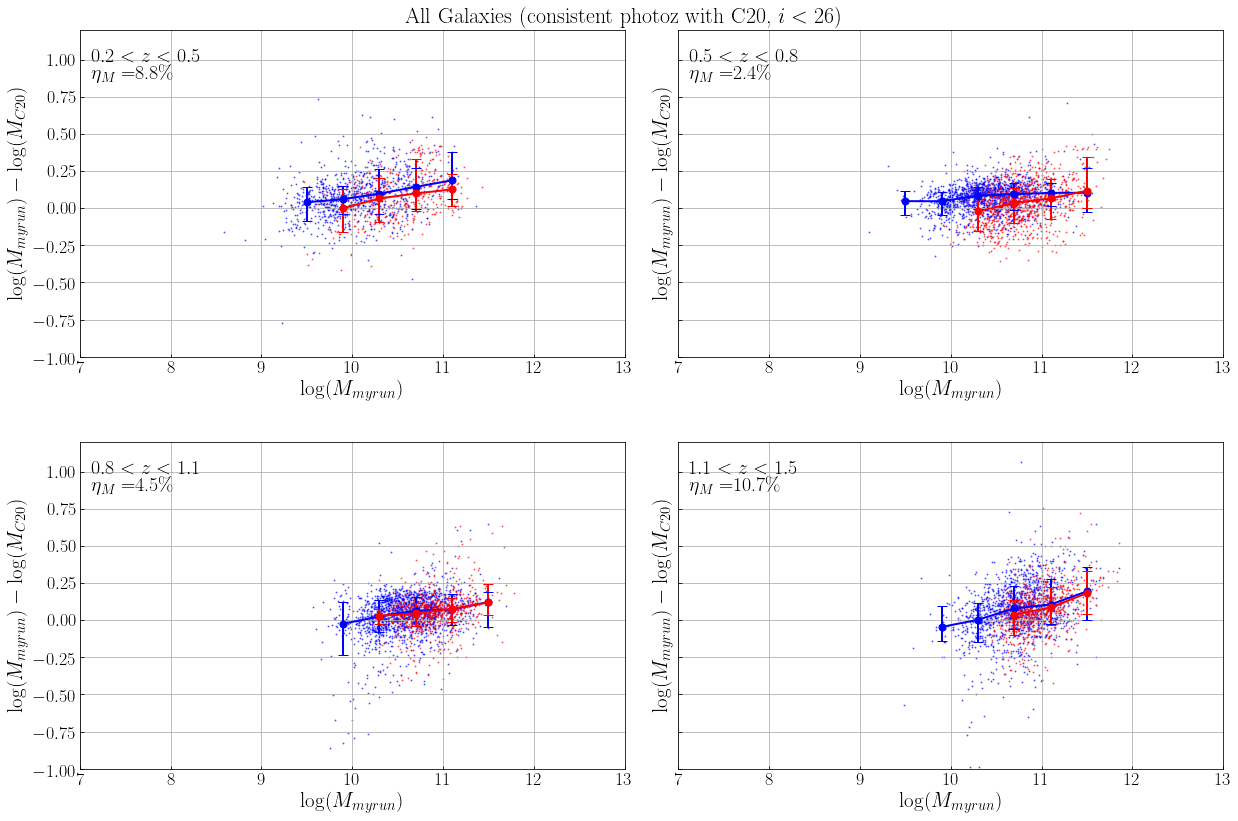

In [132]:
fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq_show = 'split' # 'all' or 'split'

for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
        
    # only show galaxies with good photo
    cond_filters = (flag_optical>3) & (flag_irac>=2)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & flag_photoz & cond_photoz_match
    # cond =  flag_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq_show == 'split':
        colors = ['b','r']
        for k,sfq in enumerate(['sf','q']):
            if sfq == 'q':
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun']==0]
            else:
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun']==1]
       
            # data to plot
            x = np.array(cat_tmp['MASS_MED_massrun'])
            y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp['lp_mass_med'])
            y[np.isnan(y)]=-99
            y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
            # plot
            im = axs[row][col].scatter(x,y,s=1,c=colors[k],alpha=0.5)
    
            # running median
            step=0.4
            counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(9.3,12.2,step))
            medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(9.3,12.2,step))
            per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(9.3,12.2,step))
            per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(9.3,12.2,step))
            
            bin_centers = bin_edges[:-1]+step/2
            medians = medians[counts>10]
            bin_centers = bin_centers[counts>10]
            per16 = per16[counts>10]
            per84 = per84[counts>10]
            axs[row][col].errorbar(bin_centers, medians, yerr=[medians-per16,per84-medians],fmt='o-',color=colors[k],linewidth=2,capsize=5,markersize=7)
            np.save('mass_err/mass_err_median_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_centers,medians,(per84-per16)/2)))
    
    else:
        # data to plot
        cat_tmp = cat_z
        x = np.array(cat_tmp['MASS_MED_massrun'])
        y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp['lp_mass_med'])
        y[np.isnan(y)]=-99
        y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
        # plot
        im = axs[row][col].scatter(x,y,s=1,c='k',alpha=0.5)
    
        # running median
        step=0.4
        counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(9.3,12.2,step))
        medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(8.5,12.2,step))
        per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(8.5,12.2,step))
        per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(8.5,12.2,step))
        
        bin_centers = bin_edges[:-1]+step/2
        medians = medians[counts>10]
        bin_centers = bin_centers[counts>10]
        per16 = per16[counts>10]
        per84 = per84[counts>10]
        
        axs[row][col].errorbar(bin_centers,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
        # histogram for delta_M
        axs[row][col].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
        axs[row][col].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')
        print("median dM's")
        print(str(z_mins[i])+'<z<'+str(z_maxs[i]),'dM='+str(round(np.median(y),2)),', massive dM='+str(round(np.median(y_massive_gal),2)),str(len(y_massive_gal)))
        np.save('mass_err/mass_err_median_all_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_edges[:-1]+step/2,medians,(per84-per16)/2)))
    
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$\log(M_{myrun}) - \log(M_{C20})$',fontsize=21)
    axs[row][col].set_xlim([7,13])
    axs[row][col].set_ylim([-1,1.2])
    axs[row][col].grid()
        
    # print out mass outlier fraction
    outlier_factor = 0.3
    num_outliers = len(cat_z[abs(cat_z['MASS_MED_massrun'] - cat_z['lp_mass_med'])>outlier_factor])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].annotate('$\eta_{M}=$'+str(round(num_outliers/len(cat_z)*100,1))+'\% ',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
     
    # cbar = fig.colorbar(im, ax=axs[row][col])
    # cbar.ax.set_ylabel(flag_name_list[i],fontsize=19)
    
plt.suptitle(fig_title,fontsize=22)
plt.tight_layout(pad=4, w_pad=2)

In [30]:
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def gau_lor(x, z, c, a ,mu, sigma):
    tau = c*(1+z)
    lor =  tau/(2*np.pi)*(1/((tau/2)**2+x**2))
    gau = a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    return lor * gau

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits


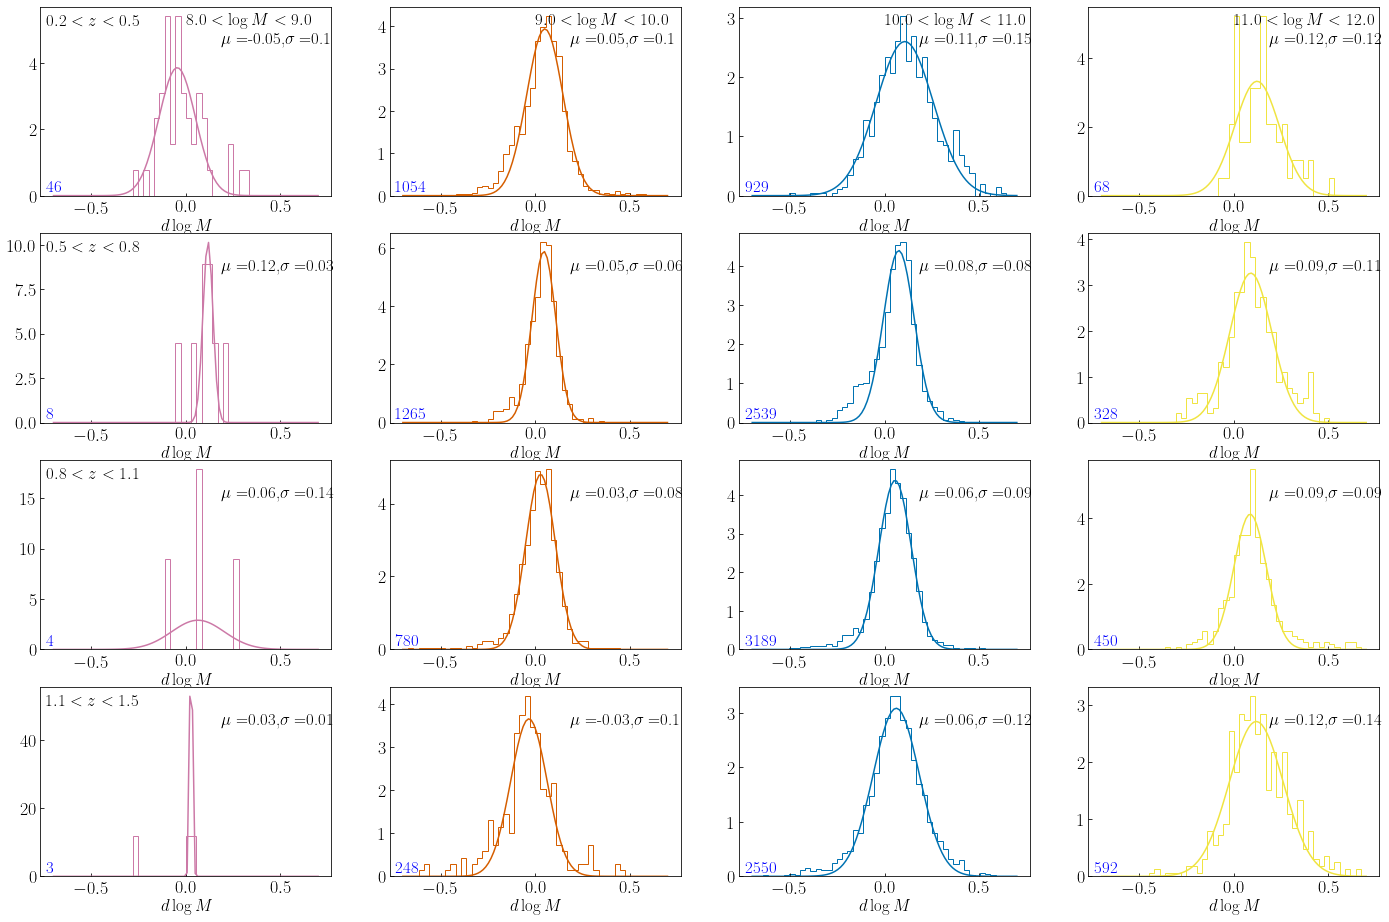

In [31]:
name_tag = '_08squdeg'
detect_limit = '_nolimit'
sfq = 'all'
print(cat_output_no_nir_mass_name)
if sfq == 'all':
    cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
else:
    cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits').replace('.fits','_sfq_added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_bins = [[8.0,9.0],[9.0,10.0],[10.,11.0],[11.0,12.0]]


fig, axs = plt.subplots(len(z_mins), len(mass_bins), figsize = (len(mass_bins)*6, len(z_mins)*4))
for i,z_min in enumerate(z_mins):
    cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    # only show galaxies with good photometry
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
    cond_filters = (flag_optical>2) & (flag_irac>=1)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & flag_photoz & cond_photoz_match
    # cond =  flag_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq == 'q':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun']==0]
    elif sfq=='sf':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun']==1]
    
    colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
    axs[i][0].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=17,color='k')
    for k,mass_bin in enumerate(mass_bins):
        if i==0: axs[0][k].annotate('$'+str(mass_bin[0])+' <\log M <'+str(mass_bin[1])+'$',xy=([0.5,0.9]),xycoords='axes fraction',fontsize=17,color='k')
        
        cat_z_mass = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>mass_bin[0],cat_z['MASS_MED_massrun']<mass_bin[1])]
        axs[i][k].annotate(str(len(cat_z_mass)),xy=([0.02,0.02]),xycoords='axes fraction',fontsize=17,color='b')
        
        # Fitting mass error distribution
        x = np.array(cat_z_mass['MASS_MED_massrun'])
        y = np.array(cat_z_mass['MASS_MED_massrun'] - cat_z_mass['lp_mass_med'])
        y[np.isnan(y)]=-99

        n,bins,patches = axs[i][k].hist(y, bins=50, density=True, range=(-0.7,0.7), histtype='step', color=colors[k])
        axs[i][k].set_xlabel('$d\log M$',fontsize=17)
        
        # Gaussian fit
        if len(n[np.isnan(n)])==0:
            popt,pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n,p0=[100,0,0.1])
            axs[i][k].annotate('$\mu=$'+str(round(popt[1],2))+',$\sigma=$'+str(round(popt[2],2)),xy=([0.62,0.8]),xycoords='axes fraction',fontsize=17,color='k')
            x_plot = np.linspace(-0.7,0.7,100)
            axs[i][k].plot(x_plot,gaussian(x_plot,popt[0],popt[1],popt[2]),color=colors[k])
        
            # Gaussian * Lorentzian fit
            # z = (z_mins[i]+z_maxs[i])/2
            # popt,pcov = curve_fit(gau_lor, bins[:-1]+(bins[1]-bins[0])/2, n, p0=[z,0.01,100,0,0.1],bounds=([z-0.01,0.00,10,-0.5,0.001],[z+0.01,0.02,500,0.5,1]))
            # print(popt)
            # axs[i][k].annotate('$\mu=$'+str(round(popt[3],2))+',$\sigma=$'+str(round(popt[4],2)),xy=([0.62,0.8]),xycoords='axes fraction',fontsize=17,color='k')
            # x_plot = np.linspace(-0.7,0.7,100)
            # axs[i][k].plot(x_plot,gau_lor(x_plot,popt[0],popt[1],popt[2],popt[3],popt[4]),color=colors[k])

In [54]:
name_tag = '_08squdeg'
detect_limit = '_nolimit'
sfq = 'all'
if sfq == 'all':
    cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
else:
    cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits').replace('.fits','_sfq_added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

for i,z_min in enumerate(z_mins):
    z_max = z_maxs[i]
    cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>z_min]
    cat_z = cat_z[cat_z['Z_ML']<z_max]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    # only show galaxies with good photo
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
    cond_filters = (flag_optical>3) & (flag_irac>=2)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & flag_photoz & cond_photoz_match
    # cond =  flag_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq == 'q':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun']==0]
    elif sfq == 'sf':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun']==1]
    
    mass_bin_size = 0.5
    mass_bin_mins = np.arange(8,12.0,mass_bin_size)
    mass_mu_list = []
    mass_sigma_list = []
    for k,mass_min in enumerate(mass_bin_mins):
        mass_max = mass_min + mass_bin_size
        cat_z_mass = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>mass_min,cat_z['MASS_MED_massrun']<mass_max)]
        if len(cat_z_mass)<=150:
            bin_enlarge = 0.15
            while len(cat_z_mass)<=150:
                cat_z_mass = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>mass_min-bin_enlarge,cat_z['MASS_MED_massrun']<mass_max+bin_enlarge)]
                n,bins = np.histogram(y, bins=50, range=(-0.7,0.7))
                bin_enlarge += 0.1
        
        # Fitting mass error distribution
        mass_diff = np.array(cat_z_mass['MASS_MED_massrun'] - cat_z_mass['lp_mass_med'])
        mass_diff[np.isnan(mass_diff)]=-99
    
        # Gaussian fit
        n,bins = np.histogram(mass_diff, bins=50, range=(-0.7,0.7))
        popt,pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n,p0=[100,0,0.1])
            
        # mass error
        mass_mu_list.append(popt[1])
        mass_sigma_list.append(popt[2])
    
    # add the right bound
    mass_bin_centers = mass_bin_mins + mass_bin_size/2
    mass_err_list = np.stack([mass_bin_centers, mass_mu_list, mass_sigma_list])
    np.save('mass_err/mass_err_myrun_'+str(sfq)+'_'+str(z_min)+'.npy',mass_err_list)
    print(str(z_min)+'<z<'+str(z_max))
    print(mass_err_list)
    print('')
            

0.2<z<0.5
[[ 8.25   8.75   9.25   9.75  10.25  10.75  11.25  11.75 ]
 [ 0.023  0.023  0.025  0.051  0.079  0.126  0.134  0.134]
 [ 0.109  0.109  0.106  0.091  0.133  0.159  0.129  0.129]]

0.5<z<0.8
[[ 8.25   8.75   9.25   9.75  10.25  10.75  11.25  11.75 ]
 [ 0.032  0.032  0.032  0.036  0.078  0.07   0.086  0.093]
 [ 0.083  0.083  0.083  0.076  0.075  0.099  0.107  0.11 ]]

0.8<z<1.1
[[8.250e+00 8.750e+00 9.250e+00 9.750e+00 1.025e+01 1.075e+01 1.125e+01
  1.175e+01]
 [4.584e-04 4.584e-04 4.584e-04 4.584e-04 3.073e-02 6.122e-02 8.456e-02
  9.946e-02]
 [9.315e-02 9.315e-02 9.315e-02 9.315e-02 9.978e-02 8.355e-02 8.480e-02
  8.481e-02]]

1.1<z<1.5
[[ 8.250e+00  8.750e+00  9.250e+00  9.750e+00  1.025e+01  1.075e+01
   1.125e+01  1.175e+01]
 [-1.443e-02 -1.443e-02 -1.443e-02 -1.443e-02  7.366e-03  6.666e-02
   1.035e-01  1.748e-01]
 [ 1.170e-01  1.170e-01  1.170e-01  1.170e-01  1.217e-01  1.238e-01
   1.310e-01  1.624e-01]]



/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


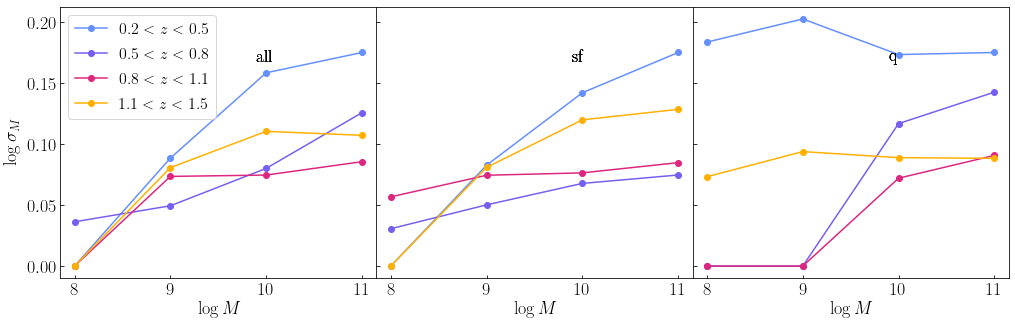

In [3]:
# remvove C20 errors
# (ignore mu's for now)
fig, axs = plt.subplots(1, 3, figsize = (17, 5),sharey=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
colors = ['#648FFF','#785EF0','#DC267F','#FFB000']

for idx, sfq in enumerate(['all','sf','q']):
    for i,z_min in enumerate(z_mins):
        mass_errs_myrun = np.load('mass_err/mass_err_myrun_'+str(sfq)+'_'+str(z_min)+'.npy')
        mass_errs_C20 = np.load('mass_err/mass_err_C20_'+str(sfq)+'_'+str(z_min)+'.npy')

        err = np.sqrt(mass_errs_myrun[2,:]**2-mass_errs_C20[2,:]**2)
        if i==0:
            err[3]=0.175
        err[np.isnan(err)]=0
        axs[idx].plot(mass_errs_myrun[0,:],err,'o-',label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',color=colors[i])
        axs[idx].annotate(sfq,xy=([0.62,0.8]),xycoords='axes fraction',fontsize=17,color='k')
    
        np.save('mass_err/mass_err_overall_'+str(sfq)+'_'+str(z_min)+'.npy',np.vstack([mass_errs_myrun[0,:],err]))
    
    axs[idx].set_xlabel('$\log M$',fontsize=18)
    axs[0].set_ylabel('$\log \sigma_M$',fontsize=18)
    axs[0].legend(fontsize=16)

fig.subplots_adjust(wspace=0)

In [63]:
fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
name_tag = '_08squdeg'
detect_limit = '_22.4'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq_show = 'all'

for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
        
    # only show galaxies with good photo
    cond_filters = (flag_optical>2) & (flag_irac>=1)
    cond = flag_photoz & cond_photoz_match & cond_filters
    cat_z = cat_z[cond]  
    
    cat_tmp = cat_z
    x = np.array(cat_tmp['MASS_MED_massrun'])
    y = np.array(cat_tmp['MASS_SUP'] - cat_tmp['MASS_INF'])/2
    y[np.isnan(y)]=-99
    y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
    # plot
    im = axs[row][col].scatter(x,y,s=1,c='k',alpha=0.5)
    
    # running median
    step=0.5
    medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(8,12.5,step))
    per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(8,12.5,step))
    per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(8,12.5,step))
    axs[row][col].errorbar(bin_edges[:-1]+step/2,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
    median_save = np.stack([bin_edges[:-1]+0.25, medians])
    np.save('merr_'+str(z_mins[i])+'_'+str(z_maxs[i]),median_save)
    
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$(\log(M_{sup}) - \log(M_{inf})z))/2$',fontsize=21)
    axs[row][col].set_xlim([7,13])
    axs[row][col].set_ylim([0,0.7])
    axs[row][col].grid()
    
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
     
    # cbar = fig.colorbar(im, ax=axs[row][col])
    # cbar.ax.set_ylabel(flag_name_list[i],fontsize=19)
    
plt.suptitle(fig_title,fontsize=22)
plt.tight_layout(pad=4, w_pad=2)

In [64]:
cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>0.2]
cat_z = cat_z[cat_z['Z_ML']<0.5]
cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
flag_photoz = cat_z['flag_photoz']==1  
cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
cond = flag_photoz & cond_photoz_match 
cat_z = cat_z[cond]
cat_z_massive = cat_z[cat_z['MASS_MED_massrun']>11.2]

In [223]:
fig, axs = plt.subplots(1, 1, figsize = (10, 8))

cat_name = output_dir+'cat_out_nonir_il_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
flag_photoz = cat_output_c20added['flag_photoz']==1  

cond_photoz_match = abs(cat_output_c20added['Z_ML_1'] - cat_output_c20added['lp_zPDF'])<0.15*(1+cat_output_c20added['lp_zPDF'])
cond_massive = cat_output_c20added['MASS_MED_massrun']>11.2
cond = flag_photoz & cond_photoz_match & cond_massive

plt.scatter(cat_output_c20added[cond]['MASS_MED_massrun'] - cat_output_c20added[cond]['lp_mass_med'], cat_output_c20added[cond]['MASS_SUP']-cat_output_c20added[cond]['MASS_INF'],s=2,c='k') 
plt.xlim([-1,2])
plt.ylim([0,1.4])

plt.xlabel(r'$\Delta M$',fontsize=19)
plt.ylabel(r'$M_{sup} - M_{inf}$',fontsize=19)

Text(0, 0.5, '$M_{sup} - M_{inf}$')

#### check dust eatimation
E(B-V)

In [69]:
# add ebv for reduced C20 catalog
# C20_reduced_cat = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits') 
# C20_raw_cat = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits')

# C20_reduced_cat.add_column(C20_raw_cat['lp_dust'])
# C20_reduced_cat.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits',overwrite=True)

In [61]:
# load catalogs

cat_no_nir_name = graham_output_dir + 'cat_out_checkdust_nonir_il_22.4_formass.fits'
cat_no_irac_name = graham_output_dir + 'cat_out_checkdust_nonirirac_il_22.4_formass.fits'
cat_no_nirirac_name = graham_output_dir + 'cat_out_checkdust_noirac_il_22.4_formass.fits'
cat_allphot_name = graham_output_dir + 'cat_out_checkdust_allphot_il_22.4_formass.fits'
cat_check_dust_names = [cat_no_nir_name, cat_no_irac_name,cat_no_nirirac_name, cat_allphot_name]

In [62]:
for i,cat_name in enumerate(cat_check_dust_names):    
#     print(cat_name)
    cat_output_name = cat_name
    cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
    combined_cat_name = cat_output_name.replace('.fits','c20added.fits')
    
    col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
    cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3=/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
    # print(cmd)
    os.system(cmd)
    
    cat_original = Table.read(cat_output_name)
    cat_matched = Table.read(combined_cat_name)
    arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
    cat_matched = cat_matched[ind]
    cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
    cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
    cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
    cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]
    
    cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < 0.3) )| \
             ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < 0.3) )
    cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < 0.3) ) 
    cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < 0.3) )
    cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < 0.3) )
    cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < 0.3) )
    cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < 0.3) )
    flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

    cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < 0.3) )
    cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < 0.3) )
    cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < 0.3) )
    cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < 0.3) )
    flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
    flag_list = [flag_optical,flag_nir,flag_irac,flag_nir]
    flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
        
    if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
        print('lengths do not match')
    else:
        print(cat_output_name)
        print(len(cat_matched),'/',len(cat_original))
        col_flag_optical = Column(name='flag_optical', data=flag_optical)
        col_flag_nir = Column(name='flag_nir', data=flag_nir)
        col_flag_irac = Column(name='flag_irac', data=flag_irac)
        cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac])
        cat_matched.write(combined_cat_name, overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_checkdust_nonir_il_22.4_formass.fits
262474 / 500000
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_checkdust_nonirirac_il_22.4_formass.fits
279550 / 500000
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_checkdust_noirac_il_22.4_formass.fits
266657 / 500000
/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_checkdust_allphot_il_22.4_formass.fits
279355 / 500000


In [63]:
cat = Table.read(cat_no_nir_name.replace('.fits','c20added.fits'))
cat = cat[cat['lp_zPDF']>0]

In [64]:
plt.hist(cat['lp_dust'],range=(-0.1,1),histtype='step',bins=20)
plt.hist(cat['EBV_BEST'],range=(-0.1,1),histtype='step',bins=20)
plt.show()

/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [75]:
fig, axs = plt.subplots(1, 1, figsize = (9, 7))

cat_z = cat[cat['Z_ML']>0.3]
cat_z = cat_z[cat_z['Z_ML']<0.5]
flag_photoz = cat_z['flag_photoz']==1  
cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
# cond_dust = abs(cat_z['lp_dust']-cat_z['EBV_BEST'])<0.1
cond = flag_photoz & cond_photoz_match # & cond_dust
cat_z = cat_z[cond]

cat_massive = cat_z[cat_z['MASS_MED_massrun']>11.3]
plt.scatter(cat_massive['MASS_MED_massrun'],cat_massive['MASS_MED_massrun']-cat_massive['lp_mass_med'],c=cat_massive['OBJ_TYPE'])

num_outlier = len(cat_massive[abs(cat_massive['MASS_MED_massrun']-cat_massive['lp_mass_med'])>0.3])
plt.colorbar()

plt.plot([11.1,11.8],[0.3,0.3],'--')
print(np.median(cat_massive['MASS_MED_massrun']-cat_massive['lp_mass_med']),num_outlier/len(cat_massive))

0.28347000000000033 0.4230769230769231


/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [79]:
plt.hist(cat_massive['i'])

(array([3., 0., 1., 5., 1., 6., 0., 5., 4., 1.]),
 array([17.407, 17.612, 17.817, 18.023, 18.228, 18.433, 18.638, 18.843,
        19.049, 19.254, 19.459]),
 <a list of 10 Patch objects>)